Final Project for BMEN4470 - Deep Learning for Biomedical Signal Processing

Project Members: Amy Jang, George Saab, Mark Kirichev

# 5 steps to implement a GAN

  1. Define the GAN architecture basen on the dataset
  2. Train the discriminator to distinguish real vs fake data
  3. Train the generator to fake data that can fool the discriminator
  4. Continue discriminator and generator training for multiple epochs
  5. Save generator model to create new, realistic fake data

In [ ]:
# Imports

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

import sys
import os
import numpy as np
from tqdm import tqdm
import scipy.io as sio
import pandas as pd

print(tf.__version__)

2.7.0


# Connecting to Google Drive and loading the data

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
data_path = '/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset'
print('Available data', os.listdir(data_path))
print('Number of files', len(os.listdir(data_path)))

Available data ['Samples', 'part_12.mat', 'part_10.mat', 'part_11.mat', 'part_1.mat', 'part_3.mat', 'part_2.mat', 'part_4.mat', 'part_5.mat', 'part_7.mat', 'part_6.mat', 'part_8.mat', 'part_9.mat', 'Divided_CSV_Files', '.ipynb_checkpoints', 'generator_model_1K.h5', 'generator_model_5K.h5', 'generator_model_2K.h5', 'generator_model_4K.h5', 'generator_model_10K.h5', 'generator_model_2_9K.h5']
Number of files 21


In [ ]:
mats_list = []
for i in range(1, 13):
  current_mat_str = '/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/part_' + str(i) + '.mat'
  mats_list.append(sio.loadmat(current_mat_str)['p'][0])

data = np.concatenate(mats_list)
total_number_of_samples = len(data)
print(f"Number of samples: {total_number_of_samples}")

Number of samples: 12000


In [ ]:
# Free the memory
del mats_list

In [ ]:
# Split data

ppg = []
abp = []
ecg = []

for sample in data:
  ppg.append(sample[0][:1000])
  abp.append(sample[1][:1000])
  ecg.append(sample[2][:1000])

pd.DataFrame(ppg).to_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/ppg.csv', index_label=False)
pd.DataFrame(abp).to_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/abp.csv', index_label=False)
pd.DataFrame(ecg).to_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/ecg.csv', index_label=False)

In [ ]:
ppg = pd.read_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/ppg.csv')
abp = pd.read_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/abp.csv')
ecg = pd.read_csv('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/Divided_CSV_Files/ecg.csv')

In [ ]:
data = np.stack((ppg, ecg), axis=-1)
X_train = data[:9600]
X_val = data[9600:10800]
X_test = data[10800:]

y_train = abp[:9600]
y_val = abp[9600:10800]
y_test = abp[10800:]

print(X_train.shape, y_train.shape)

(9600, 1000, 2) (9600, 1000)


In [ ]:
# getting the global max and min values becuase we'll need them
# for a normalization later

min_X_train = np.min(X_train)
max_X_train = np.max(X_train)

print(min_X_train)
print(max_X_train)

-7.49609375
4.5


# GAN Code Implementation

In [ ]:
# Defining global constants

signal_shape = (1000, 2)
d_loss_list = []
g_loss_list = []
epoch_times = []

How LeakyReLu works

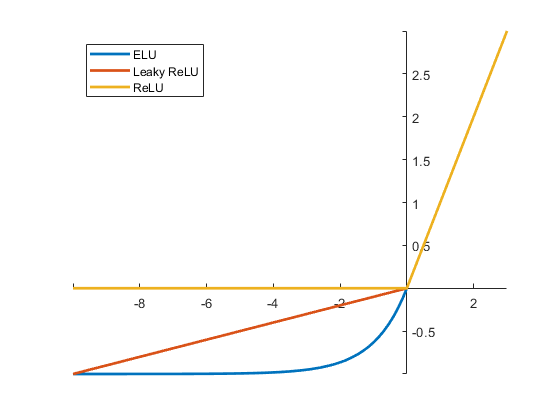

* The alpha parameter in the following implementation represents how large the angle with the x-axis is.

In [ ]:
def build_generator():

    # Defining the constants
    alpha_val = 0.2
    momentum_val = 0.8
    number_of_dense_layers = 3
    initial_dense_layer_neurons = 256
    
    # Initializing the dense layers for the generator

    dense_layers = []
    for i in range(number_of_dense_layers):
      dense_layers.append(initial_dense_layer_neurons << i)

    # 1D array of size 100 (latent vector / noise)
    noise_shape = (100, )


    # Step 1: Define the GAN architecture basen on the dataset      
    model = Sequential()

    # Adding 'number_of_dense_layers' sets of:
    # (dense layer, LeakyReLu, BatchNormalization)
    for i, dense_layer_neurons_number in enumerate(dense_layers):
      model.add(Dense(dense_layer_neurons_number)) if not i == 0 else model.add(Dense(dense_layer_neurons_number, input_shape=noise_shape))
      model.add(LeakyReLU(alpha=alpha_val))
      model.add(BatchNormalization(momentum=momentum_val))
    
    # Adding a final dense layer
    model.add(Dense(np.prod(signal_shape), activation='tanh'))
    model.add(Reshape(signal_shape))

    model.build(input_shape=signal_shape)
    model.summary()

    noise = Input(shape=noise_shape)
    signal = model(noise)    # Generated signal

    return Model(noise, signal)

In [ ]:
def build_discriminator():

    # Defining the constants
    alpha_val = 0.2
    dense_layers = [512, 256]

    model = Sequential()

    model.add(Flatten(input_shape=signal_shape))

    for dense_layer_neurons_number in dense_layers:
      model.add(Dense(dense_layer_neurons_number))
      model.add(LeakyReLU(alpha=alpha_val))
    
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    signal = Input(shape=signal_shape)
    validity = model(signal)

    return Model(signal, validity)

In [ ]:
def normalization(num):
  k = 2 / (max_X_train - min_X_train)
  m = (- min_X_train - max_X_train) / (max_X_train - min_X_train)
  norm = k * num + m
  return norm


for sample in X_train:
  for arr in sample:
    arr[0] = normalization(arr[0])
    arr[1] = normalization(arr[1])

In [ ]:
def train(epochs, batch_size=128):

    half_batch = int(batch_size / 2)

    # Now we start iterating over the epochs and training both our discriminator
    # and generator, one after another. We train the discriminator first, by
    # feeding it real data (the half_batch) then training the generator with 
    # both real and fake data (separately). After that, we compute the loss and
    # continue to iterate until both the generator and discriminator have been trained.
    for epoch in tqdm(range(epochs)):

        # Save the times so we can analyze them after
        initial_time_for_epoch = time.clock()

        #  Train Discriminator

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        signals = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake signals
        gen_signals = generator.predict(noise)

        # Train the discriminator on real and fake signals, separately

        d_loss_real = discriminator.train_on_batch(signals, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_signals, np.zeros((half_batch, 1)))
        
        # calculate the average square error of the real & false predictions
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

        # Now it's time to train our generator. Its idea is to 'fool' the discriminator
        # meaning that we're trying to get the discriminator to mark the fake signals
        # as real and vice-versa

        # Create noise vectors as input for generator.
        noise = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (true i.e. one)
        # This is where the genrator is trying to trick discriminator into believing
        # the generated image is true (hence value of true (one) for y)
        valid_y = np.array([1] * batch_size)

        # Now get the general loss by training both at the same time
        g_loss = combined.train_on_batch(noise, valid_y)


        # In order to have some type of logging, we print the data
        print (f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")
        
        d_loss_list.append(d_loss[0])
        g_loss_list.append(g_loss)

        if epochs % 1000 == 0:
          number_of_thousands = int(epochs / 1000)
          discriminator_weights_file = f'/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/GAN_Weights/discriminator_{number_of_thousands}K'
          generator_weights_file = f'/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/GAN_Weights/discriminator_{number_of_thousands}K'
          discriminator.save_weights(discriminator_weights_file)
          generator.save_weights(generator_weights_file)
        
        end_time_for_epoch = time.clock()
        epoch_times.append(end_time_for_epoch - initial_time_for_epoch)

In [ ]:
# Adding a timer callback to track the time

class timecallback(Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.clock()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.clock() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()

In [ ]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))
signal = generator(z)

discriminator.trainable = False
valid = discriminator(signal)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# timetaken = timecallback()

train(epochs=10000, batch_size=32)
generator.save('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/generator_model_10K.h5')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2000)              0         
                                                                 
 dense_21 (Dense)            (None, 512)               1024512   
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,156,097
Trainable params: 1,156,097
No

  0%|          | 0/2900 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  0%|          | 2/2900 [00:01<38:56,  1.24it/s]  

0 [D loss: 0.8460448384284973] [G loss: 0.5840660333633423]
1 [D loss: 0.3798147067427635] [G loss: 0.5788468718528748]


  0%|          | 5/2900 [00:02<12:56,  3.73it/s]

2 [D loss: 0.3345600115135312] [G loss: 0.6716054677963257]
3 [D loss: 0.32848938181996346] [G loss: 0.6837583780288696]
4 [D loss: 0.2859234972856939] [G loss: 0.8090491890907288]


  0%|          | 7/2900 [00:02<09:06,  5.29it/s]

5 [D loss: 0.30915539897978306] [G loss: 0.9003835320472717]
6 [D loss: 0.26107405917719007] [G loss: 1.0167410373687744]
7 [D loss: 0.22578755486756563] [G loss: 1.1930824518203735]


  0%|          | 11/2900 [00:02<06:18,  7.63it/s]

8 [D loss: 0.19242506939917803] [G loss: 1.3130030632019043]
9 [D loss: 0.1619121041148901] [G loss: 1.5161491632461548]
10 [D loss: 0.1120433947071433] [G loss: 1.6209056377410889]


  0%|          | 13/2900 [00:02<05:45,  8.37it/s]

11 [D loss: 0.12133883871138096] [G loss: 1.8036301136016846]
12 [D loss: 0.1155848354101181] [G loss: 1.8763461112976074]
13 [D loss: 0.10881046298891306] [G loss: 2.1042237281799316]


  1%|          | 17/2900 [00:03<04:51,  9.88it/s]

14 [D loss: 0.09346380736678839] [G loss: 2.2603416442871094]
15 [D loss: 0.08584804646670818] [G loss: 2.3673770427703857]
16 [D loss: 0.06772660091519356] [G loss: 2.4490585327148438]


  1%|          | 19/2900 [00:03<04:47, 10.02it/s]

17 [D loss: 0.0632405485957861] [G loss: 2.617215156555176]
18 [D loss: 0.06807428365573287] [G loss: 2.7114763259887695]
19 [D loss: 0.04942700173705816] [G loss: 2.7066056728363037]


  1%|          | 23/2900 [00:03<04:31, 10.60it/s]

20 [D loss: 0.04360039532184601] [G loss: 2.9527950286865234]
21 [D loss: 0.04588076286017895] [G loss: 2.87658429145813]
22 [D loss: 0.03711625374853611] [G loss: 2.8873648643493652]


  1%|          | 25/2900 [00:04<04:28, 10.71it/s]

23 [D loss: 0.04059783276170492] [G loss: 3.0408718585968018]
24 [D loss: 0.04315059073269367] [G loss: 3.1461362838745117]
25 [D loss: 0.04356288583949208] [G loss: 3.250411033630371]


  1%|          | 29/2900 [00:04<04:24, 10.87it/s]

26 [D loss: 0.025640866719186306] [G loss: 3.1697726249694824]
27 [D loss: 0.052439638413488865] [G loss: 3.1268014907836914]
28 [D loss: 0.029215638292953372] [G loss: 3.315176010131836]


  1%|          | 31/2900 [00:04<04:25, 10.81it/s]

29 [D loss: 0.024198561906814575] [G loss: 3.297377109527588]
30 [D loss: 0.02744990773499012] [G loss: 3.377086639404297]
31 [D loss: 0.03066268563270569] [G loss: 3.5008435249328613]


  1%|          | 35/2900 [00:04<04:23, 10.88it/s]

32 [D loss: 0.024575758259743452] [G loss: 3.3687825202941895]
33 [D loss: 0.018595206551253796] [G loss: 3.290134906768799]
34 [D loss: 0.03345695277675986] [G loss: 3.454719305038452]


  1%|▏         | 37/2900 [00:05<04:30, 10.59it/s]

35 [D loss: 0.02611401746980846] [G loss: 3.4486441612243652]
36 [D loss: 0.02418672852218151] [G loss: 3.4676527976989746]


  1%|▏         | 39/2900 [00:05<04:38, 10.28it/s]

37 [D loss: 0.03026900812983513] [G loss: 3.531895637512207]
38 [D loss: 0.01862108986824751] [G loss: 3.620978355407715]
39 [D loss: 0.027427793014794588] [G loss: 3.654456615447998]


  1%|▏         | 43/2900 [00:05<04:30, 10.55it/s]

40 [D loss: 0.024944011587649584] [G loss: 3.7592005729675293]
41 [D loss: 0.017517883563414216] [G loss: 3.817003011703491]
42 [D loss: 0.027071467600762844] [G loss: 3.835623264312744]


  2%|▏         | 45/2900 [00:05<04:29, 10.59it/s]

43 [D loss: 0.024552926770411432] [G loss: 3.7950997352600098]
44 [D loss: 0.02183670736849308] [G loss: 3.8822240829467773]


  2%|▏         | 47/2900 [00:06<04:47,  9.91it/s]

45 [D loss: 0.019390468718484044] [G loss: 3.942701816558838]
46 [D loss: 0.01358159282244742] [G loss: 3.766920804977417]


  2%|▏         | 49/2900 [00:06<04:36, 10.32it/s]

47 [D loss: 0.023707262706011534] [G loss: 3.7572438716888428]
48 [D loss: 0.023096871562302113] [G loss: 3.8593149185180664]
49 [D loss: 0.01511548669077456] [G loss: 3.971104145050049]


  2%|▏         | 53/2900 [00:06<04:37, 10.27it/s]

50 [D loss: 0.023858332308009267] [G loss: 3.731903553009033]
51 [D loss: 0.015038039535284042] [G loss: 3.92366099357605]
52 [D loss: 0.022682152222841978] [G loss: 4.059813976287842]


  2%|▏         | 55/2900 [00:06<04:42, 10.07it/s]

53 [D loss: 0.01372521836310625] [G loss: 4.013984680175781]
54 [D loss: 0.017389332642778754] [G loss: 4.008632659912109]
55 [D loss: 0.011644544545561075] [G loss: 3.9049510955810547]


  2%|▏         | 58/2900 [00:07<04:53,  9.68it/s]

56 [D loss: 0.016369029879570007] [G loss: 3.9223222732543945]
57 [D loss: 0.01786890998482704] [G loss: 3.9079971313476562]


  2%|▏         | 61/2900 [00:07<04:39, 10.15it/s]

58 [D loss: 0.024237531004473567] [G loss: 3.9008941650390625]
59 [D loss: 0.024900659918785095] [G loss: 3.9485816955566406]
60 [D loss: 0.013933397363871336] [G loss: 4.201864242553711]


  2%|▏         | 63/2900 [00:07<04:33, 10.37it/s]

61 [D loss: 0.018066001124680042] [G loss: 4.145510673522949]
62 [D loss: 0.011212297016754746] [G loss: 4.128252983093262]
63 [D loss: 0.01799402362667024] [G loss: 4.106876850128174]


  2%|▏         | 65/2900 [00:07<04:28, 10.56it/s]

64 [D loss: 0.018560148775577545] [G loss: 4.157172203063965]
65 [D loss: 0.014565455261617899] [G loss: 4.259650230407715]


  2%|▏         | 69/2900 [00:08<04:30, 10.46it/s]

66 [D loss: 0.018127721268683672] [G loss: 4.017101764678955]
67 [D loss: 0.016896250541321933] [G loss: 4.182572364807129]
68 [D loss: 0.011498789303004742] [G loss: 4.031680107116699]


  2%|▏         | 71/2900 [00:08<04:24, 10.70it/s]

69 [D loss: 0.028005451429635286] [G loss: 4.229511737823486]
70 [D loss: 0.011334193870425224] [G loss: 4.321847915649414]
71 [D loss: 0.026974304113537073] [G loss: 4.434864044189453]


  3%|▎         | 75/2900 [00:08<04:29, 10.47it/s]

72 [D loss: 0.013447381323203444] [G loss: 4.5494866371154785]
73 [D loss: 0.016290481202304363] [G loss: 4.5986328125]
74 [D loss: 0.01452773087657988] [G loss: 4.481799125671387]


  3%|▎         | 77/2900 [00:09<04:28, 10.52it/s]

75 [D loss: 0.014696214930154383] [G loss: 4.394744873046875]
76 [D loss: 0.014630737248808146] [G loss: 4.3236002922058105]
77 [D loss: 0.010756210656836629] [G loss: 4.426802635192871]


  3%|▎         | 81/2900 [00:09<04:18, 10.90it/s]

78 [D loss: 0.010438251658342779] [G loss: 4.462871074676514]
79 [D loss: 0.01190987741574645] [G loss: 4.5279107093811035]
80 [D loss: 0.02408202039077878] [G loss: 4.63416051864624]


  3%|▎         | 83/2900 [00:09<04:19, 10.85it/s]

81 [D loss: 0.01949280919507146] [G loss: 4.70888614654541]
82 [D loss: 0.013149747624993324] [G loss: 4.857356071472168]
83 [D loss: 0.010865324642509222] [G loss: 4.92699670791626]


  3%|▎         | 87/2900 [00:09<04:14, 11.05it/s]

84 [D loss: 0.013314050622284412] [G loss: 4.920253753662109]
85 [D loss: 0.011424494441598654] [G loss: 4.7879743576049805]
86 [D loss: 0.006514030043035746] [G loss: 4.80647087097168]


  3%|▎         | 89/2900 [00:10<04:16, 10.94it/s]

87 [D loss: 0.006679019192233682] [G loss: 4.713520526885986]
88 [D loss: 0.01605848828330636] [G loss: 4.720426559448242]
89 [D loss: 0.01569965248927474] [G loss: 5.005131721496582]


  3%|▎         | 93/2900 [00:10<04:12, 11.11it/s]

90 [D loss: 0.00730164023116231] [G loss: 4.9516730308532715]
91 [D loss: 0.01228629145771265] [G loss: 4.999215602874756]
92 [D loss: 0.009417828172445297] [G loss: 4.953043460845947]


  3%|▎         | 95/2900 [00:10<04:18, 10.83it/s]

93 [D loss: 0.00865246239118278] [G loss: 4.862586975097656]
94 [D loss: 0.010678799357265234] [G loss: 4.772214889526367]
95 [D loss: 0.010017975699156523] [G loss: 4.831570148468018]


  3%|▎         | 99/2900 [00:11<04:17, 10.90it/s]

96 [D loss: 0.005616804584860802] [G loss: 4.621365547180176]
97 [D loss: 0.01719245850108564] [G loss: 4.794399738311768]
98 [D loss: 0.012548749800771475] [G loss: 5.262682914733887]


  3%|▎         | 101/2900 [00:11<04:20, 10.73it/s]

99 [D loss: 0.012387290596961975] [G loss: 5.20414924621582]
100 [D loss: 0.011815850157290697] [G loss: 5.02663516998291]
101 [D loss: 0.015616984805092216] [G loss: 5.258506774902344]


  4%|▎         | 105/2900 [00:11<04:13, 11.03it/s]

102 [D loss: 0.013179950881749392] [G loss: 5.60915470123291]
103 [D loss: 0.013675351161509752] [G loss: 5.347531318664551]
104 [D loss: 0.005520437378436327] [G loss: 5.085624694824219]


  4%|▎         | 107/2900 [00:11<04:17, 10.87it/s]

105 [D loss: 0.007199550746008754] [G loss: 5.044094085693359]
106 [D loss: 0.008028993848711252] [G loss: 5.0404205322265625]
107 [D loss: 0.008369272109121084] [G loss: 4.886861801147461]


  4%|▍         | 111/2900 [00:12<04:23, 10.58it/s]

108 [D loss: 0.022257422097027302] [G loss: 5.624638557434082]
109 [D loss: 0.012067739851772785] [G loss: 5.589993000030518]
110 [D loss: 0.010799341835081577] [G loss: 4.988442420959473]


  4%|▍         | 113/2900 [00:12<04:24, 10.53it/s]

111 [D loss: 0.010097404010593891] [G loss: 5.270333290100098]
112 [D loss: 0.01018601399846375] [G loss: 5.663351058959961]
113 [D loss: 0.00650241575203836] [G loss: 5.259379863739014]


  4%|▍         | 117/2900 [00:12<04:24, 10.52it/s]

114 [D loss: 0.016032435931265354] [G loss: 5.338074684143066]
115 [D loss: 0.01974272122606635] [G loss: 5.337121963500977]
116 [D loss: 0.01007576147094369] [G loss: 5.114365577697754]


  4%|▍         | 119/2900 [00:12<04:24, 10.52it/s]

117 [D loss: 0.009889273438602686] [G loss: 5.380470275878906]
118 [D loss: 0.015323927393183112] [G loss: 5.866481304168701]
119 [D loss: 0.02421616017818451] [G loss: 4.6125993728637695]


  4%|▍         | 123/2900 [00:13<04:17, 10.78it/s]

120 [D loss: 0.019724099955055863] [G loss: 5.1701202392578125]
121 [D loss: 0.03587887104367837] [G loss: 7.011980056762695]
122 [D loss: 0.025331606157124043] [G loss: 8.20833969116211]


  4%|▍         | 125/2900 [00:13<04:28, 10.33it/s]

123 [D loss: 0.25224023684859276] [G loss: 14.107650756835938]
124 [D loss: 4.443448901176453] [G loss: 4.066164970397949]
125 [D loss: 1.816510802737172] [G loss: 2.151298761367798]


  4%|▍         | 129/2900 [00:13<04:27, 10.35it/s]

126 [D loss: 1.0469213093008705] [G loss: 3.953108787536621]
127 [D loss: 0.6895977384187972] [G loss: 3.868020534515381]
128 [D loss: 0.22953122047510988] [G loss: 4.242779731750488]


  5%|▍         | 131/2900 [00:14<04:26, 10.38it/s]

129 [D loss: 0.10091408275184222] [G loss: 3.769287347793579]
130 [D loss: 0.07387482118792832] [G loss: 3.7154006958007812]
131 [D loss: 0.11011072259861976] [G loss: 3.3653247356414795]


  5%|▍         | 135/2900 [00:14<04:26, 10.37it/s]

132 [D loss: 0.1877987151965499] [G loss: 3.552644729614258]
133 [D loss: 0.11482260003685951] [G loss: 3.7176647186279297]
134 [D loss: 0.11244954913854599] [G loss: 3.3181629180908203]


  5%|▍         | 137/2900 [00:14<04:25, 10.41it/s]

135 [D loss: 0.06812755577266216] [G loss: 2.670686721801758]
136 [D loss: 0.1922739390283823] [G loss: 3.0162830352783203]
137 [D loss: 0.09315389581024647] [G loss: 3.2314515113830566]


  5%|▍         | 141/2900 [00:15<04:19, 10.62it/s]

138 [D loss: 0.18315907567739487] [G loss: 2.901311159133911]
139 [D loss: 0.13487041555345058] [G loss: 2.7064151763916016]
140 [D loss: 0.19746819883584976] [G loss: 2.468353271484375]


  5%|▍         | 143/2900 [00:15<04:23, 10.45it/s]

141 [D loss: 0.14412528183311224] [G loss: 2.9010660648345947]
142 [D loss: 0.18688270822167397] [G loss: 3.0114402770996094]
143 [D loss: 0.21832237392663956] [G loss: 3.4437782764434814]


  5%|▌         | 147/2900 [00:15<04:29, 10.22it/s]

144 [D loss: 0.1461727675050497] [G loss: 2.5913288593292236]
145 [D loss: 0.4509710781276226] [G loss: 3.182960033416748]
146 [D loss: 0.6487294435501099] [G loss: 1.4218074083328247]


  5%|▌         | 149/2900 [00:15<04:31, 10.13it/s]

147 [D loss: 0.340920221991837] [G loss: 2.0353362560272217]
148 [D loss: 0.20506626507267356] [G loss: 3.527647018432617]


  5%|▌         | 151/2900 [00:16<04:29, 10.18it/s]

149 [D loss: 0.14570219814777374] [G loss: 3.6915817260742188]
150 [D loss: 0.11894840002059937] [G loss: 2.7157087326049805]
151 [D loss: 0.1967703476548195] [G loss: 2.371000289916992]


  5%|▌         | 154/2900 [00:16<04:42,  9.73it/s]

152 [D loss: 0.15388543531298637] [G loss: 2.7012224197387695]
153 [D loss: 0.278007660061121] [G loss: 2.2389135360717773]


  5%|▌         | 156/2900 [00:16<04:30, 10.14it/s]

154 [D loss: 0.11880918592214584] [G loss: 2.486755847930908]
155 [D loss: 0.2707286700606346] [G loss: 3.1014316082000732]
156 [D loss: 0.36557332426309586] [G loss: 2.465714931488037]


  6%|▌         | 160/2900 [00:16<04:28, 10.20it/s]

157 [D loss: 0.15413154289126396] [G loss: 2.723867177963257]
158 [D loss: 0.23563969135284424] [G loss: 3.4088711738586426]
159 [D loss: 0.22121644020080566] [G loss: 2.634812116622925]


  6%|▌         | 162/2900 [00:17<04:22, 10.41it/s]

160 [D loss: 0.15643832460045815] [G loss: 2.8431999683380127]
161 [D loss: 0.16407053172588348] [G loss: 2.3694753646850586]
162 [D loss: 0.20754289627075195] [G loss: 2.757150888442993]


  6%|▌         | 164/2900 [00:17<04:16, 10.66it/s]

163 [D loss: 0.2699158489704132] [G loss: 2.4562900066375732]
164 [D loss: 0.24650805816054344] [G loss: 3.0479533672332764]


  6%|▌         | 168/2900 [00:17<04:15, 10.71it/s]

165 [D loss: 0.2352355718612671] [G loss: 2.4521288871765137]
166 [D loss: 0.13414734229445457] [G loss: 2.7745635509490967]
167 [D loss: 0.16738378256559372] [G loss: 2.9365172386169434]


  6%|▌         | 170/2900 [00:17<04:19, 10.52it/s]

168 [D loss: 0.13601266592741013] [G loss: 2.5408477783203125]
169 [D loss: 0.1566443368792534] [G loss: 2.8944549560546875]
170 [D loss: 0.20232385396957397] [G loss: 2.58955454826355]


  6%|▌         | 172/2900 [00:18<04:13, 10.78it/s]

171 [D loss: 0.17022286728024483] [G loss: 3.2312960624694824]
172 [D loss: 0.177937351167202] [G loss: 2.2695469856262207]


  6%|▌         | 176/2900 [00:18<04:21, 10.41it/s]

173 [D loss: 0.1687761228531599] [G loss: 2.936978340148926]
174 [D loss: 0.1080884225666523] [G loss: 3.095846176147461]
175 [D loss: 0.19586758315563202] [G loss: 2.6144676208496094]


  6%|▌         | 178/2900 [00:18<04:18, 10.52it/s]

176 [D loss: 0.14565355237573385] [G loss: 2.8382365703582764]
177 [D loss: 0.07767784222960472] [G loss: 3.205434799194336]
178 [D loss: 0.1291300766170025] [G loss: 2.9654688835144043]


  6%|▌         | 181/2900 [00:19<05:46,  7.84it/s]

179 [D loss: 0.10917691141366959] [G loss: 2.9196276664733887]
180 [D loss: 0.14350540190935135] [G loss: 2.8259639739990234]


  6%|▋         | 183/2900 [00:19<05:13,  8.66it/s]

181 [D loss: 0.1445675939321518] [G loss: 3.190824031829834]
182 [D loss: 0.28843165934085846] [G loss: 2.675347328186035]
183 [D loss: 0.13074150122702122] [G loss: 3.365910291671753]


  6%|▋         | 186/2900 [00:19<05:17,  8.56it/s]

184 [D loss: 0.19326938688755035] [G loss: 2.666553258895874]
185 [D loss: 0.11477408092468977] [G loss: 3.4894590377807617]


  7%|▋         | 189/2900 [00:20<05:58,  7.56it/s]

186 [D loss: 0.11159304156899452] [G loss: 3.012572765350342]
187 [D loss: 0.10162820480763912] [G loss: 3.2529749870300293]
188 [D loss: 0.15845604240894318] [G loss: 3.322725772857666]


  7%|▋         | 191/2900 [00:20<05:27,  8.26it/s]

189 [D loss: 0.15868137031793594] [G loss: 3.1390438079833984]
190 [D loss: 0.11929741688072681] [G loss: 3.9189553260803223]


  7%|▋         | 193/2900 [00:20<05:43,  7.89it/s]

191 [D loss: 0.19282883405685425] [G loss: 2.6116628646850586]
192 [D loss: 0.06347059179097414] [G loss: 2.6901087760925293]


  7%|▋         | 195/2900 [00:21<06:32,  6.90it/s]

193 [D loss: 0.13577171973884106] [G loss: 3.8649861812591553]
194 [D loss: 0.2480589747428894] [G loss: 3.267162561416626]
195 [D loss: 0.049963099882006645] [G loss: 3.5087196826934814]


  7%|▋         | 197/2900 [00:21<05:39,  7.97it/s]

196 [D loss: 0.10375170409679413] [G loss: 3.1920523643493652]
197 [D loss: 0.06496809795498848] [G loss: 2.910285472869873]


  7%|▋         | 201/2900 [00:21<04:48,  9.35it/s]

198 [D loss: 0.10680250450968742] [G loss: 3.418416738510132]
199 [D loss: 0.13768336176872253] [G loss: 3.477944850921631]
200 [D loss: 0.08873033337295055] [G loss: 3.758441209793091]


  7%|▋         | 203/2900 [00:21<04:35,  9.78it/s]

201 [D loss: 0.15145929157733917] [G loss: 3.608386993408203]
202 [D loss: 0.09614642709493637] [G loss: 4.020771026611328]
203 [D loss: 0.17396977543830872] [G loss: 2.6737918853759766]


  7%|▋         | 207/2900 [00:22<04:29,  9.98it/s]

204 [D loss: 0.07983388938009739] [G loss: 3.530925750732422]
205 [D loss: 0.10345754027366638] [G loss: 4.014350891113281]
206 [D loss: 0.08978341147303581] [G loss: 2.8565845489501953]


  7%|▋         | 209/2900 [00:22<04:28, 10.02it/s]

207 [D loss: 0.08075885660946369] [G loss: 3.641608476638794]
208 [D loss: 0.12806729972362518] [G loss: 4.4275360107421875]
209 [D loss: 0.17404747009277344] [G loss: 3.4499125480651855]


  7%|▋         | 213/2900 [00:22<04:16, 10.49it/s]

210 [D loss: 0.07405214570462704] [G loss: 4.290859222412109]
211 [D loss: 0.12610280886292458] [G loss: 3.765972375869751]
212 [D loss: 0.10951114818453789] [G loss: 4.716595649719238]


  7%|▋         | 215/2900 [00:22<04:15, 10.50it/s]

213 [D loss: 0.4296770691871643] [G loss: 3.466841459274292]
214 [D loss: 0.0449354313313961] [G loss: 4.963766574859619]
215 [D loss: 0.1390559896826744] [G loss: 2.9280214309692383]


  8%|▊         | 219/2900 [00:23<04:16, 10.46it/s]

216 [D loss: 0.061380837112665176] [G loss: 3.633645534515381]
217 [D loss: 0.05188562162220478] [G loss: 4.226723670959473]
218 [D loss: 0.12482696026563644] [G loss: 2.9071974754333496]


  8%|▊         | 221/2900 [00:23<04:13, 10.57it/s]

219 [D loss: 0.07430017273873091] [G loss: 4.04656982421875]
220 [D loss: 0.15526270493865013] [G loss: 4.248814582824707]
221 [D loss: 0.07981614023447037] [G loss: 3.907993793487549]


  8%|▊         | 225/2900 [00:23<04:17, 10.37it/s]

222 [D loss: 0.1925988309085369] [G loss: 4.824367523193359]
223 [D loss: 0.44726990908384323] [G loss: 5.004012107849121]
224 [D loss: 0.11608199030160904] [G loss: 6.163978099822998]


  8%|▊         | 227/2900 [00:24<04:12, 10.57it/s]

225 [D loss: 0.32787930220365524] [G loss: 3.3655247688293457]
226 [D loss: 0.12796862237155437] [G loss: 4.9009599685668945]
227 [D loss: 0.1940842717885971] [G loss: 4.728183269500732]


  8%|▊         | 231/2900 [00:24<04:18, 10.32it/s]

228 [D loss: 0.09791561588644981] [G loss: 4.612067222595215]
229 [D loss: 0.1819840967655182] [G loss: 2.939552068710327]
230 [D loss: 0.11886352673172951] [G loss: 5.252806186676025]


  8%|▊         | 233/2900 [00:24<04:09, 10.68it/s]

231 [D loss: 2.3352513015270233] [G loss: 0.6805298328399658]
232 [D loss: 0.6992400125600398] [G loss: 3.175166606903076]
233 [D loss: 0.08480556309223175] [G loss: 4.950401306152344]


  8%|▊         | 235/2900 [00:24<04:04, 10.88it/s]

234 [D loss: 0.7289499640464783] [G loss: 2.5182905197143555]
235 [D loss: 0.1855265237390995] [G loss: 4.011534214019775]


  8%|▊         | 239/2900 [00:25<04:15, 10.41it/s]

236 [D loss: 0.0702691525220871] [G loss: 3.9549367427825928]
237 [D loss: 0.17106099426746368] [G loss: 2.717374086380005]
238 [D loss: 0.1954074762761593] [G loss: 3.2155866622924805]


  8%|▊         | 241/2900 [00:25<04:10, 10.62it/s]

239 [D loss: 0.2551797404885292] [G loss: 2.3287293910980225]
240 [D loss: 0.2017872240394354] [G loss: 3.746601104736328]
241 [D loss: 0.527426153421402] [G loss: 4.006302833557129]


  8%|▊         | 243/2900 [00:25<04:06, 10.79it/s]

242 [D loss: 0.1572021059691906] [G loss: 3.472820281982422]
243 [D loss: 0.25788046419620514] [G loss: 3.307950973510742]


  9%|▊         | 247/2900 [00:25<04:10, 10.58it/s]

244 [D loss: 0.30615559220314026] [G loss: 3.007472515106201]
245 [D loss: 0.20601661503314972] [G loss: 3.6851272583007812]
246 [D loss: 1.171869307756424] [G loss: 1.4591772556304932]


  9%|▊         | 249/2900 [00:26<04:12, 10.51it/s]

247 [D loss: 0.2185500916093588] [G loss: 3.359279155731201]
248 [D loss: 0.2511121854186058] [G loss: 4.173059940338135]
249 [D loss: 0.47293736040592194] [G loss: 2.69649076461792]


  9%|▊         | 253/2900 [00:26<04:08, 10.64it/s]

250 [D loss: 0.20665555447340012] [G loss: 3.5979983806610107]
251 [D loss: 0.3121751695871353] [G loss: 3.37257719039917]
252 [D loss: 0.39425475895404816] [G loss: 4.3262176513671875]


  9%|▉         | 255/2900 [00:26<04:09, 10.60it/s]

253 [D loss: 0.3311845064163208] [G loss: 3.8283276557922363]
254 [D loss: 0.26416367292404175] [G loss: 3.376436471939087]
255 [D loss: 0.21284119784832] [G loss: 2.5764856338500977]


  9%|▉         | 259/2900 [00:27<04:06, 10.71it/s]

256 [D loss: 0.19792664051055908] [G loss: 4.090867042541504]
257 [D loss: 1.5354046821594238] [G loss: 0.5482463836669922]
258 [D loss: 0.8208171278238297] [G loss: 2.943997383117676]


  9%|▉         | 261/2900 [00:27<04:05, 10.75it/s]

259 [D loss: 0.593226969242096] [G loss: 2.7155466079711914]
260 [D loss: 0.2042505219578743] [G loss: 2.971920967102051]
261 [D loss: 0.5072420239448547] [G loss: 3.2602896690368652]


  9%|▉         | 265/2900 [00:27<04:01, 10.89it/s]

262 [D loss: 0.3519735634326935] [G loss: 3.026615619659424]
263 [D loss: 0.28295935690402985] [G loss: 3.2348551750183105]
264 [D loss: 0.4256586283445358] [G loss: 3.149840831756592]


  9%|▉         | 267/2900 [00:27<04:01, 10.92it/s]

265 [D loss: 0.3060375601053238] [G loss: 2.721329689025879]
266 [D loss: 0.3828740790486336] [G loss: 3.926997423171997]
267 [D loss: 1.2475629448890686] [G loss: 0.9369358420372009]


  9%|▉         | 269/2900 [00:28<04:04, 10.75it/s]

268 [D loss: 0.8371512964367867] [G loss: 3.8486366271972656]
269 [D loss: 0.9583429098129272] [G loss: 1.6527929306030273]


  9%|▉         | 273/2900 [00:28<04:10, 10.49it/s]

270 [D loss: 0.27852684259414673] [G loss: 2.005229949951172]
271 [D loss: 0.33486826717853546] [G loss: 3.4128153324127197]
272 [D loss: 0.5700089335441589] [G loss: 2.2540245056152344]


  9%|▉         | 275/2900 [00:28<04:20, 10.08it/s]

273 [D loss: 0.2355658933520317] [G loss: 2.2625789642333984]
274 [D loss: 0.47733931243419647] [G loss: 2.7704358100891113]
275 [D loss: 0.475019246339798] [G loss: 2.2479844093322754]


 10%|▉         | 279/2900 [00:28<04:00, 10.90it/s]

276 [D loss: 0.23869404941797256] [G loss: 2.9531314373016357]
277 [D loss: 0.5254398286342621] [G loss: 2.6178743839263916]
278 [D loss: 0.34414204955101013] [G loss: 3.616253614425659]


 10%|▉         | 281/2900 [00:29<04:14, 10.29it/s]

279 [D loss: 0.5499780774116516] [G loss: 1.6485990285873413]
280 [D loss: 0.3187248483300209] [G loss: 3.7786366939544678]
281 [D loss: 1.0952646136283875] [G loss: 1.2739465236663818]


 10%|▉         | 285/2900 [00:29<04:05, 10.64it/s]

282 [D loss: 0.3700841888785362] [G loss: 2.7400388717651367]
283 [D loss: 0.7065586149692535] [G loss: 1.987886667251587]
284 [D loss: 0.23919551819562912] [G loss: 3.172104835510254]


 10%|▉         | 287/2900 [00:29<04:06, 10.62it/s]

285 [D loss: 0.4275358319282532] [G loss: 2.6863889694213867]
286 [D loss: 0.3807947486639023] [G loss: 3.5269856452941895]
287 [D loss: 0.6045843958854675] [G loss: 2.3300225734710693]


 10%|█         | 291/2900 [00:30<04:03, 10.71it/s]

288 [D loss: 0.26329921931028366] [G loss: 3.0736517906188965]
289 [D loss: 0.7535361647605896] [G loss: 2.9141128063201904]
290 [D loss: 0.5391605794429779] [G loss: 3.0570569038391113]


 10%|█         | 293/2900 [00:30<04:10, 10.41it/s]

291 [D loss: 0.5470120012760162] [G loss: 2.391355276107788]
292 [D loss: 0.35204923152923584] [G loss: 4.21461296081543]
293 [D loss: 1.6624018549919128] [G loss: 0.5684994459152222]


 10%|█         | 297/2900 [00:30<03:58, 10.94it/s]

294 [D loss: 0.5863503664731979] [G loss: 2.0739588737487793]
295 [D loss: 0.4859645664691925] [G loss: 2.554978609085083]
296 [D loss: 0.7129043340682983] [G loss: 2.5569872856140137]


 10%|█         | 299/2900 [00:30<03:59, 10.86it/s]

297 [D loss: 0.49665407836437225] [G loss: 2.3765158653259277]
298 [D loss: 0.3738698959350586] [G loss: 2.148571491241455]
299 [D loss: 0.29586878418922424] [G loss: 2.270049571990967]


 10%|█         | 303/2900 [00:31<04:04, 10.63it/s]

300 [D loss: 0.4006091356277466] [G loss: 2.4573588371276855]
301 [D loss: 0.43328872323036194] [G loss: 2.3736438751220703]
302 [D loss: 0.4706595242023468] [G loss: 2.657583475112915]


 11%|█         | 305/2900 [00:31<04:06, 10.52it/s]

303 [D loss: 0.5637240260839462] [G loss: 3.3325631618499756]
304 [D loss: 0.9181846082210541] [G loss: 1.5098353624343872]
305 [D loss: 0.4199031889438629] [G loss: 3.552900552749634]


 11%|█         | 309/2900 [00:31<04:04, 10.59it/s]

306 [D loss: 1.218136966228485] [G loss: 1.3291971683502197]
307 [D loss: 0.39979222416877747] [G loss: 2.77012300491333]
308 [D loss: 0.721007227897644] [G loss: 1.454127550125122]


 11%|█         | 311/2900 [00:32<04:04, 10.60it/s]

309 [D loss: 0.43977007269859314] [G loss: 3.2447099685668945]
310 [D loss: 0.7196281254291534] [G loss: 1.6642805337905884]
311 [D loss: 0.32621993869543076] [G loss: 2.8297793865203857]


 11%|█         | 315/2900 [00:32<04:06, 10.49it/s]

312 [D loss: 0.6340657770633698] [G loss: 2.784290313720703]
313 [D loss: 0.4459851384162903] [G loss: 2.748255729675293]
314 [D loss: 0.8345499634742737] [G loss: 2.273012161254883]


 11%|█         | 317/2900 [00:32<04:15, 10.13it/s]

315 [D loss: 0.37734830379486084] [G loss: 2.8697004318237305]
316 [D loss: 0.8430871963500977] [G loss: 2.0876059532165527]
317 [D loss: 0.4407311677932739] [G loss: 2.1674206256866455]


 11%|█         | 321/2900 [00:33<04:06, 10.44it/s]

318 [D loss: 0.5122435092926025] [G loss: 3.1787142753601074]
319 [D loss: 0.8764906227588654] [G loss: 1.3221368789672852]
320 [D loss: 0.5552520155906677] [G loss: 2.0689926147460938]


 11%|█         | 323/2900 [00:33<04:11, 10.23it/s]

321 [D loss: 0.5254239439964294] [G loss: 2.6439714431762695]
322 [D loss: 0.5453663766384125] [G loss: 2.5407214164733887]


 11%|█         | 325/2900 [00:33<04:11, 10.24it/s]

323 [D loss: 0.5050168633460999] [G loss: 3.042564868927002]
324 [D loss: 0.7408183515071869] [G loss: 1.675120234489441]
325 [D loss: 0.4678274691104889] [G loss: 3.0375356674194336]


 11%|█▏        | 329/2900 [00:33<04:03, 10.57it/s]

326 [D loss: 1.0947169065475464] [G loss: 1.3887019157409668]
327 [D loss: 0.47812172770500183] [G loss: 3.5126118659973145]
328 [D loss: 1.505097210407257] [G loss: 0.646382212638855]


 11%|█▏        | 331/2900 [00:33<03:58, 10.78it/s]

329 [D loss: 0.7341189756989479] [G loss: 1.6480011940002441]
330 [D loss: 0.5943788886070251] [G loss: 2.2483506202697754]
331 [D loss: 0.6198886632919312] [G loss: 1.8970470428466797]


 12%|█▏        | 335/2900 [00:34<03:57, 10.82it/s]

332 [D loss: 0.5567613244056702] [G loss: 1.8996000289916992]
333 [D loss: 0.4575723260641098] [G loss: 2.245513916015625]
334 [D loss: 0.6027790904045105] [G loss: 2.3004636764526367]


 12%|█▏        | 337/2900 [00:34<03:58, 10.74it/s]

335 [D loss: 0.5579136162996292] [G loss: 2.3352749347686768]
336 [D loss: 0.6307645440101624] [G loss: 2.193920612335205]
337 [D loss: 0.6501764953136444] [G loss: 2.1670265197753906]


 12%|█▏        | 341/2900 [00:34<03:55, 10.87it/s]

338 [D loss: 0.7088603079319] [G loss: 2.3036251068115234]
339 [D loss: 0.7474572956562042] [G loss: 1.7684295177459717]
340 [D loss: 0.6488729119300842] [G loss: 2.024550676345825]


 12%|█▏        | 343/2900 [00:35<03:53, 10.95it/s]

341 [D loss: 0.732900470495224] [G loss: 2.077347755432129]
342 [D loss: 0.6661130785942078] [G loss: 2.3825345039367676]
343 [D loss: 0.9206726253032684] [G loss: 1.1710320711135864]


 12%|█▏        | 347/2900 [00:35<04:01, 10.57it/s]

344 [D loss: 0.5990420877933502] [G loss: 2.5899624824523926]
345 [D loss: 0.98051917552948] [G loss: 1.139888048171997]
346 [D loss: 0.6829692423343658] [G loss: 2.336566686630249]


 12%|█▏        | 349/2900 [00:35<04:04, 10.43it/s]

347 [D loss: 0.9815970361232758] [G loss: 1.3732550144195557]
348 [D loss: 0.5659231841564178] [G loss: 1.6400431394577026]
349 [D loss: 0.5196221172809601] [G loss: 1.4938993453979492]


 12%|█▏        | 353/2900 [00:35<03:56, 10.76it/s]

350 [D loss: 0.5200681686401367] [G loss: 2.1387970447540283]
351 [D loss: 0.7027785181999207] [G loss: 1.787262201309204]
352 [D loss: 0.7263080179691315] [G loss: 1.8849313259124756]


 12%|█▏        | 355/2900 [00:36<04:08, 10.23it/s]

353 [D loss: 0.6952908039093018] [G loss: 1.638406753540039]
354 [D loss: 0.6576128005981445] [G loss: 2.136218309402466]


 12%|█▏        | 357/2900 [00:36<04:19,  9.79it/s]

355 [D loss: 0.7000706791877747] [G loss: 1.3425168991088867]
356 [D loss: 0.5588821768760681] [G loss: 1.9564207792282104]


 12%|█▏        | 360/2900 [00:36<04:09, 10.19it/s]

357 [D loss: 0.7030551135540009] [G loss: 1.4543993473052979]
358 [D loss: 0.5912663340568542] [G loss: 2.1106817722320557]
359 [D loss: 0.6455277800559998] [G loss: 1.4620325565338135]


 12%|█▏        | 362/2900 [00:36<04:07, 10.27it/s]

360 [D loss: 0.5992176532745361] [G loss: 2.245882034301758]
361 [D loss: 0.7991809844970703] [G loss: 1.552170753479004]
362 [D loss: 0.5898666679859161] [G loss: 2.0931038856506348]


 13%|█▎        | 366/2900 [00:37<03:57, 10.69it/s]

363 [D loss: 0.7650512158870697] [G loss: 1.4685964584350586]
364 [D loss: 0.6366667151451111] [G loss: 2.20945143699646]
365 [D loss: 0.763512372970581] [G loss: 1.3766758441925049]


 13%|█▎        | 368/2900 [00:37<04:03, 10.41it/s]

366 [D loss: 0.6173898279666901] [G loss: 2.3463683128356934]
367 [D loss: 0.8325026035308838] [G loss: 1.3331210613250732]
368 [D loss: 0.6326796114444733] [G loss: 2.375255584716797]


 13%|█▎        | 372/2900 [00:37<04:06, 10.26it/s]

369 [D loss: 0.9319227933883667] [G loss: 1.1474207639694214]
370 [D loss: 0.5951848924160004] [G loss: 2.3954877853393555]
371 [D loss: 1.0501282811164856] [G loss: 1.00483238697052]


 13%|█▎        | 374/2900 [00:38<04:07, 10.19it/s]

372 [D loss: 0.6706173419952393] [G loss: 1.7039271593093872]
373 [D loss: 0.8125278949737549] [G loss: 1.385611653327942]
374 [D loss: 0.6574757695198059] [G loss: 1.781189203262329]


 13%|█▎        | 378/2900 [00:38<04:03, 10.37it/s]

375 [D loss: 0.764592319726944] [G loss: 1.5917189121246338]
376 [D loss: 0.7294031083583832] [G loss: 1.551826000213623]
377 [D loss: 0.700558066368103] [G loss: 1.6759867668151855]


 13%|█▎        | 380/2900 [00:38<03:57, 10.59it/s]

378 [D loss: 0.6695017218589783] [G loss: 1.7175564765930176]
379 [D loss: 0.6883177757263184] [G loss: 1.8593437671661377]
380 [D loss: 0.6963097751140594] [G loss: 1.5859436988830566]


 13%|█▎        | 382/2900 [00:38<03:55, 10.69it/s]

381 [D loss: 0.6858990788459778] [G loss: 1.9425818920135498]
382 [D loss: 0.7622277736663818] [G loss: 1.6534771919250488]


 13%|█▎        | 386/2900 [00:39<03:59, 10.51it/s]

383 [D loss: 0.7627174258232117] [G loss: 1.5788447856903076]
384 [D loss: 0.6934688091278076] [G loss: 1.7399793863296509]
385 [D loss: 0.8023998141288757] [G loss: 1.5812599658966064]


 13%|█▎        | 388/2900 [00:39<03:59, 10.47it/s]

386 [D loss: 0.72333163022995] [G loss: 1.930045247077942]
387 [D loss: 0.7626650631427765] [G loss: 1.4491937160491943]
388 [D loss: 0.6946864128112793] [G loss: 1.801499605178833]


 14%|█▎        | 392/2900 [00:39<03:57, 10.57it/s]

389 [D loss: 0.788284182548523] [G loss: 1.3639099597930908]
390 [D loss: 0.6845731139183044] [G loss: 1.8608887195587158]
391 [D loss: 0.8402853608131409] [G loss: 1.3818094730377197]


 14%|█▎        | 394/2900 [00:39<03:54, 10.68it/s]

392 [D loss: 0.6722258627414703] [G loss: 1.9083447456359863]
393 [D loss: 0.8553817868232727] [G loss: 1.222259521484375]
394 [D loss: 0.7175599932670593] [G loss: 1.7248713970184326]


 14%|█▎        | 396/2900 [00:40<03:57, 10.56it/s]

395 [D loss: 0.8493026196956635] [G loss: 1.4335410594940186]
396 [D loss: 0.726753443479538] [G loss: 1.6901276111602783]


 14%|█▎        | 398/2900 [00:40<04:01, 10.35it/s]

397 [D loss: 0.7477975487709045] [G loss: 1.390063762664795]
398 [D loss: 0.6717482209205627] [G loss: 1.605262279510498]


 14%|█▍        | 402/2900 [00:40<04:04, 10.22it/s]

399 [D loss: 0.7585480511188507] [G loss: 1.4416182041168213]
400 [D loss: 0.8090314865112305] [G loss: 1.2210716009140015]
401 [D loss: 0.6911458671092987] [G loss: 1.7819604873657227]


 14%|█▍        | 404/2900 [00:40<04:04, 10.22it/s]

402 [D loss: 0.840965211391449] [G loss: 1.2026770114898682]
403 [D loss: 0.6884004771709442] [G loss: 1.6804306507110596]
404 [D loss: 0.8078797459602356] [G loss: 1.1507182121276855]


 14%|█▍        | 408/2900 [00:41<03:54, 10.63it/s]

405 [D loss: 0.7118476927280426] [G loss: 1.7507169246673584]
406 [D loss: 0.8294860124588013] [G loss: 1.0957443714141846]
407 [D loss: 0.6897248923778534] [G loss: 1.730893850326538]


 14%|█▍        | 410/2900 [00:41<03:54, 10.62it/s]

408 [D loss: 0.820084273815155] [G loss: 1.259415626525879]
409 [D loss: 0.672416627407074] [G loss: 1.7235933542251587]
410 [D loss: 0.7790455222129822] [G loss: 1.3915376663208008]


 14%|█▍        | 414/2900 [00:41<03:52, 10.70it/s]

411 [D loss: 0.686832070350647] [G loss: 1.6265206336975098]
412 [D loss: 0.7292798459529877] [G loss: 1.621589183807373]
413 [D loss: 0.7568877339363098] [G loss: 1.4619865417480469]


 14%|█▍        | 416/2900 [00:42<03:51, 10.75it/s]

414 [D loss: 0.724583625793457] [G loss: 1.4032998085021973]
415 [D loss: 0.6898708045482635] [G loss: 1.5742534399032593]
416 [D loss: 0.7535850405693054] [G loss: 1.2476022243499756]


 14%|█▍        | 420/2900 [00:42<04:04, 10.13it/s]

417 [D loss: 0.6873290538787842] [G loss: 1.667555332183838]
418 [D loss: 0.7981585562229156] [G loss: 1.2737324237823486]
419 [D loss: 0.6637592613697052] [G loss: 1.6797642707824707]


 15%|█▍        | 422/2900 [00:42<04:03, 10.16it/s]

420 [D loss: 0.753507673740387] [G loss: 1.4180676937103271]
421 [D loss: 0.7035897672176361] [G loss: 1.6695008277893066]
422 [D loss: 0.7821846008300781] [G loss: 1.2872681617736816]


 15%|█▍        | 426/2900 [00:43<03:50, 10.74it/s]

423 [D loss: 0.7432760298252106] [G loss: 1.432659387588501]
424 [D loss: 0.7400127053260803] [G loss: 1.5525133609771729]
425 [D loss: 0.7805553078651428] [G loss: 1.3118683099746704]


 15%|█▍        | 428/2900 [00:43<03:54, 10.53it/s]

426 [D loss: 0.7427013218402863] [G loss: 1.42808198928833]
427 [D loss: 0.7675778269767761] [G loss: 1.3342413902282715]
428 [D loss: 0.7060987651348114] [G loss: 1.4857327938079834]


 15%|█▍        | 432/2900 [00:43<03:55, 10.50it/s]

429 [D loss: 0.7125751078128815] [G loss: 1.4682731628417969]
430 [D loss: 0.7683489918708801] [G loss: 1.407141923904419]
431 [D loss: 0.7104603350162506] [G loss: 1.637476921081543]


 15%|█▍        | 434/2900 [00:43<03:54, 10.50it/s]

432 [D loss: 0.768306702375412] [G loss: 1.330610990524292]
433 [D loss: 0.6947270631790161] [G loss: 1.6073824167251587]


 15%|█▌        | 436/2900 [00:44<04:02, 10.16it/s]

434 [D loss: 0.8155015110969543] [G loss: 1.1890181303024292]
435 [D loss: 0.7716613709926605] [G loss: 1.293168067932129]
436 [D loss: 0.7380733489990234] [G loss: 1.4760758876800537]


 15%|█▌        | 440/2900 [00:44<03:57, 10.35it/s]

437 [D loss: 0.7384957075119019] [G loss: 1.455786943435669]
438 [D loss: 0.7242347896099091] [G loss: 1.6747336387634277]
439 [D loss: 0.8165324032306671] [G loss: 1.2121505737304688]


 15%|█▌        | 442/2900 [00:44<04:12,  9.72it/s]

440 [D loss: 0.7535594999790192] [G loss: 1.4311785697937012]
441 [D loss: 0.8060384392738342] [G loss: 1.193389892578125]
442 [D loss: 0.7282840609550476] [G loss: 1.3698512315750122]


 15%|█▌        | 446/2900 [00:44<03:58, 10.28it/s]

443 [D loss: 0.7314787209033966] [G loss: 1.3643760681152344]
444 [D loss: 0.7249387204647064] [G loss: 1.4342275857925415]
445 [D loss: 0.7762558460235596] [G loss: 1.2506632804870605]


 15%|█▌        | 448/2900 [00:45<03:58, 10.29it/s]

446 [D loss: 0.7029143571853638] [G loss: 1.3638709783554077]
447 [D loss: 0.7531142830848694] [G loss: 1.3432341814041138]
448 [D loss: 0.7530296146869659] [G loss: 1.3118659257888794]


 16%|█▌        | 452/2900 [00:45<03:52, 10.53it/s]

449 [D loss: 0.7339855134487152] [G loss: 1.3060611486434937]
450 [D loss: 0.7395126223564148] [G loss: 1.3423891067504883]
451 [D loss: 0.7164660096168518] [G loss: 1.496788501739502]


 16%|█▌        | 454/2900 [00:45<03:47, 10.76it/s]

452 [D loss: 0.7570403814315796] [G loss: 1.372257947921753]
453 [D loss: 0.7313121259212494] [G loss: 1.3357166051864624]
454 [D loss: 0.7623881101608276] [G loss: 1.285143256187439]


 16%|█▌        | 458/2900 [00:46<03:43, 10.95it/s]

455 [D loss: 0.7301681041717529] [G loss: 1.273108720779419]
456 [D loss: 0.7250027060508728] [G loss: 1.5471065044403076]
457 [D loss: 0.76747065782547] [G loss: 1.2128725051879883]


 16%|█▌        | 460/2900 [00:46<03:43, 10.93it/s]

458 [D loss: 0.7170460522174835] [G loss: 1.2314610481262207]
459 [D loss: 0.7385791838169098] [G loss: 1.4477994441986084]
460 [D loss: 0.8004796802997589] [G loss: 1.1894724369049072]


 16%|█▌        | 464/2900 [00:46<03:45, 10.81it/s]

461 [D loss: 0.7469991445541382] [G loss: 1.2380802631378174]
462 [D loss: 0.745019793510437] [G loss: 1.214202880859375]
463 [D loss: 0.7083244919776917] [G loss: 1.4954050779342651]


 16%|█▌        | 466/2900 [00:46<03:46, 10.72it/s]

464 [D loss: 0.8030799627304077] [G loss: 1.1228091716766357]
465 [D loss: 0.7132750451564789] [G loss: 1.308218240737915]
466 [D loss: 0.7304225265979767] [G loss: 1.3114030361175537]


 16%|█▌        | 470/2900 [00:47<03:51, 10.49it/s]

467 [D loss: 0.756292998790741] [G loss: 1.464048147201538]
468 [D loss: 0.7387893497943878] [G loss: 1.4339344501495361]
469 [D loss: 0.7477762401103973] [G loss: 1.4148948192596436]


 16%|█▋        | 472/2900 [00:47<03:52, 10.43it/s]

470 [D loss: 0.7544699609279633] [G loss: 1.2346367835998535]
471 [D loss: 0.7430602610111237] [G loss: 1.2664647102355957]


 16%|█▋        | 474/2900 [00:47<03:57, 10.20it/s]

472 [D loss: 0.7398056387901306] [G loss: 1.2976981401443481]
473 [D loss: 0.7244928479194641] [G loss: 1.4132323265075684]
474 [D loss: 0.7656789124011993] [G loss: 1.210399866104126]


 16%|█▋        | 476/2900 [00:47<03:54, 10.36it/s]

475 [D loss: 0.7247252464294434] [G loss: 1.5368696451187134]


 16%|█▋        | 478/2900 [00:48<05:30,  7.34it/s]

476 [D loss: 0.8196425139904022] [G loss: 1.0783851146697998]
477 [D loss: 0.7255010604858398] [G loss: 1.2273266315460205]
478 [D loss: 0.719957560300827] [G loss: 1.3725929260253906]


 17%|█▋        | 480/2900 [00:48<04:54,  8.22it/s]

479 [D loss: 0.7414021193981171] [G loss: 1.2960858345031738]
480 [D loss: 0.7225682735443115] [G loss: 1.3751964569091797]
481 [D loss: 0.7604019045829773] [G loss: 1.1516538858413696]


 17%|█▋        | 484/2900 [00:48<04:35,  8.76it/s]

482 [D loss: 0.7158063650131226] [G loss: 1.3087506294250488]
483 [D loss: 0.7554279565811157] [G loss: 1.1417326927185059]


 17%|█▋        | 487/2900 [00:49<04:18,  9.33it/s]

484 [D loss: 0.7076152265071869] [G loss: 1.2755310535430908]
485 [D loss: 0.7706360816955566] [G loss: 1.1445496082305908]
486 [D loss: 0.712035745382309] [G loss: 1.3266162872314453]


 17%|█▋        | 490/2900 [00:49<04:04,  9.84it/s]

487 [D loss: 0.753793478012085] [G loss: 1.270873785018921]
488 [D loss: 0.7310080528259277] [G loss: 1.2637360095977783]
489 [D loss: 0.7377913296222687] [G loss: 1.23528254032135]


 17%|█▋        | 492/2900 [00:49<04:06,  9.76it/s]

490 [D loss: 0.7408739328384399] [G loss: 1.3354072570800781]
491 [D loss: 0.750531017780304] [G loss: 1.2123191356658936]


 17%|█▋        | 494/2900 [00:49<04:06,  9.76it/s]

492 [D loss: 0.7236487865447998] [G loss: 1.3737760782241821]
493 [D loss: 0.7429719269275665] [G loss: 1.2390327453613281]
494 [D loss: 0.7254313826560974] [G loss: 1.2991349697113037]


 17%|█▋        | 498/2900 [00:50<03:46, 10.62it/s]

495 [D loss: 0.7347475290298462] [G loss: 1.2391271591186523]
496 [D loss: 0.7208212316036224] [G loss: 1.187750220298767]
497 [D loss: 0.7135037183761597] [G loss: 1.3447411060333252]


 17%|█▋        | 500/2900 [00:50<03:46, 10.60it/s]

498 [D loss: 0.7431198358535767] [G loss: 1.2172341346740723]
499 [D loss: 0.7296875715255737] [G loss: 1.3033080101013184]
500 [D loss: 0.7251612842082977] [G loss: 1.3186755180358887]


 17%|█▋        | 504/2900 [00:50<03:51, 10.35it/s]

501 [D loss: 0.759771078824997] [G loss: 1.2418673038482666]
502 [D loss: 0.7119112312793732] [G loss: 1.3117855787277222]
503 [D loss: 0.7411354184150696] [G loss: 1.2538906335830688]


 17%|█▋        | 506/2900 [00:51<03:53, 10.24it/s]

504 [D loss: 0.7317202389240265] [G loss: 1.2575024366378784]
505 [D loss: 0.7422658503055573] [G loss: 1.142216682434082]
506 [D loss: 0.7177293300628662] [G loss: 1.2350759506225586]


 18%|█▊        | 508/2900 [00:51<03:48, 10.46it/s]

507 [D loss: 0.741173505783081] [G loss: 1.1868587732315063]
508 [D loss: 0.7343246936798096] [G loss: 1.1649017333984375]


 18%|█▊        | 512/2900 [00:51<03:58, 10.01it/s]

509 [D loss: 0.7255169749259949] [G loss: 1.185245394706726]
510 [D loss: 0.7342467308044434] [G loss: 1.1399606466293335]
511 [D loss: 0.7138879299163818] [G loss: 1.249523401260376]


 18%|█▊        | 514/2900 [00:51<03:56, 10.07it/s]

512 [D loss: 0.7583773136138916] [G loss: 1.1458828449249268]
513 [D loss: 0.7290514409542084] [G loss: 1.223652720451355]
514 [D loss: 0.7479301691055298] [G loss: 1.2050297260284424]


 18%|█▊        | 518/2900 [00:52<03:51, 10.30it/s]

515 [D loss: 0.7293731272220612] [G loss: 1.105229377746582]
516 [D loss: 0.6987072825431824] [G loss: 1.1944434642791748]
517 [D loss: 0.7354701161384583] [G loss: 1.1296555995941162]


 18%|█▊        | 520/2900 [00:52<03:50, 10.31it/s]

518 [D loss: 0.7149598598480225] [G loss: 1.28525710105896]
519 [D loss: 0.7415762841701508] [G loss: 1.1784863471984863]
520 [D loss: 0.7299660444259644] [G loss: 1.1447011232376099]


 18%|█▊        | 523/2900 [00:52<04:03,  9.75it/s]

521 [D loss: 0.7158801555633545] [G loss: 1.2335362434387207]
522 [D loss: 0.7257556915283203] [G loss: 1.23052978515625]
523 [D loss: 0.725181519985199] [G loss: 1.1546084880828857]


 18%|█▊        | 526/2900 [00:53<04:05,  9.69it/s]

524 [D loss: 0.7177731692790985] [G loss: 1.1691409349441528]
525 [D loss: 0.7161675095558167] [G loss: 1.2568602561950684]


 18%|█▊        | 528/2900 [00:53<04:03,  9.74it/s]

526 [D loss: 0.7255224287509918] [G loss: 1.2114531993865967]
527 [D loss: 0.7334994375705719] [G loss: 1.2316936254501343]
528 [D loss: 0.7424397766590118] [G loss: 1.1793040037155151]


 18%|█▊        | 532/2900 [00:53<03:34, 11.02it/s]

529 [D loss: 0.7164334654808044] [G loss: 1.2857933044433594]
530 [D loss: 0.7412457764148712] [G loss: 1.1809864044189453]
531 [D loss: 0.720790833234787] [G loss: 1.2029505968093872]


 18%|█▊        | 534/2900 [00:53<03:40, 10.74it/s]

532 [D loss: 0.7342797517776489] [G loss: 1.0751187801361084]
533 [D loss: 0.7308111488819122] [G loss: 1.1315319538116455]
534 [D loss: 0.7025599181652069] [G loss: 1.2210044860839844]


 19%|█▊        | 538/2900 [00:54<03:42, 10.61it/s]

535 [D loss: 0.719178706407547] [G loss: 1.2256669998168945]
536 [D loss: 0.7077274918556213] [G loss: 1.221550464630127]
537 [D loss: 0.7310799658298492] [G loss: 1.1173774003982544]


 19%|█▊        | 540/2900 [00:54<03:36, 10.88it/s]

538 [D loss: 0.7251855731010437] [G loss: 1.1216334104537964]
539 [D loss: 0.711781919002533] [G loss: 1.2247674465179443]
540 [D loss: 0.735554963350296] [G loss: 1.1404625177383423]


 19%|█▊        | 542/2900 [00:54<03:40, 10.67it/s]

541 [D loss: 0.7211893796920776] [G loss: 1.1939011812210083]
542 [D loss: 0.7218616604804993] [G loss: 1.0980054140090942]
543 [D loss: 0.7120275497436523] [G loss: 1.1544561386108398]

 19%|█▉        | 546/2900 [00:54<03:47, 10.34it/s]


544 [D loss: 0.6931595802307129] [G loss: 1.2246631383895874]
545 [D loss: 0.7091076672077179] [G loss: 1.2748632431030273]


 19%|█▉        | 548/2900 [00:55<03:43, 10.54it/s]

546 [D loss: 0.7075238823890686] [G loss: 1.3256549835205078]
547 [D loss: 0.7045038938522339] [G loss: 1.2037047147750854]
548 [D loss: 0.6981083452701569] [G loss: 1.1816580295562744]


 19%|█▉        | 550/2900 [00:55<03:49, 10.25it/s]

549 [D loss: 0.7176190614700317] [G loss: 1.1613256931304932]
550 [D loss: 0.6861923038959503] [G loss: 1.2786798477172852]


 19%|█▉        | 554/2900 [00:55<03:50, 10.16it/s]

551 [D loss: 0.7195337116718292] [G loss: 1.2120344638824463]
552 [D loss: 0.7114003002643585] [G loss: 1.3198208808898926]
553 [D loss: 0.7530074715614319] [G loss: 1.0590782165527344]


 19%|█▉        | 556/2900 [00:55<03:50, 10.15it/s]

554 [D loss: 0.7052818834781647] [G loss: 1.1611738204956055]
555 [D loss: 0.7205220460891724] [G loss: 1.1401560306549072]
556 [D loss: 0.7150371372699738] [G loss: 1.1443140506744385]


 19%|█▉        | 560/2900 [00:56<03:48, 10.24it/s]

557 [D loss: 0.7211833596229553] [G loss: 1.1685290336608887]
558 [D loss: 0.7190347015857697] [G loss: 1.1790610551834106]
559 [D loss: 0.7338041663169861] [G loss: 1.1650974750518799]


 19%|█▉        | 562/2900 [00:56<03:46, 10.31it/s]

560 [D loss: 0.7226527333259583] [G loss: 1.1363914012908936]
561 [D loss: 0.7150393128395081] [G loss: 1.2061715126037598]


 19%|█▉        | 564/2900 [00:56<03:53, 10.00it/s]

562 [D loss: 0.7193398177623749] [G loss: 1.147369146347046]
563 [D loss: 0.7218733727931976] [G loss: 1.2115402221679688]
564 [D loss: 0.7454982995986938] [G loss: 1.0695687532424927]


 20%|█▉        | 568/2900 [00:57<03:47, 10.26it/s]

565 [D loss: 0.6939700245857239] [G loss: 1.1865652799606323]
566 [D loss: 0.7222285866737366] [G loss: 1.2295384407043457]
567 [D loss: 0.7063987851142883] [G loss: 1.1960270404815674]


 20%|█▉        | 570/2900 [00:57<03:45, 10.34it/s]

568 [D loss: 0.7156040072441101] [G loss: 1.1628835201263428]
569 [D loss: 0.7265863120555878] [G loss: 1.0940945148468018]
570 [D loss: 0.6930417716503143] [G loss: 1.1968399286270142]


 20%|█▉        | 574/2900 [00:57<03:38, 10.65it/s]

571 [D loss: 0.7066963911056519] [G loss: 1.1877851486206055]
572 [D loss: 0.7185719609260559] [G loss: 1.1404848098754883]
573 [D loss: 0.7018885910511017] [G loss: 1.1483049392700195]


 20%|█▉        | 576/2900 [00:57<03:40, 10.55it/s]

574 [D loss: 0.7114006876945496] [G loss: 1.1812649965286255]
575 [D loss: 0.7268009781837463] [G loss: 1.0853254795074463]


 20%|█▉        | 578/2900 [00:58<03:45, 10.29it/s]

576 [D loss: 0.7118844389915466] [G loss: 1.109147548675537]
577 [D loss: 0.7039145529270172] [G loss: 1.1562778949737549]
578 [D loss: 0.7117776870727539] [G loss: 1.1688532829284668]


 20%|██        | 582/2900 [00:58<03:36, 10.73it/s]

579 [D loss: 0.72174271941185] [G loss: 1.136389970779419]
580 [D loss: 0.7151827812194824] [G loss: 1.1615281105041504]
581 [D loss: 0.7318482100963593] [G loss: 1.0564923286437988]


 20%|██        | 584/2900 [00:58<03:36, 10.69it/s]

582 [D loss: 0.7005636394023895] [G loss: 1.1191983222961426]
583 [D loss: 0.7043276727199554] [G loss: 1.124263048171997]
584 [D loss: 0.6943158507347107] [G loss: 1.217666506767273]


 20%|██        | 588/2900 [00:58<03:35, 10.72it/s]

585 [D loss: 0.7325138747692108] [G loss: 1.101209282875061]
586 [D loss: 0.6974462270736694] [G loss: 1.1429247856140137]
587 [D loss: 0.7043349742889404] [G loss: 1.141456127166748]


 20%|██        | 590/2900 [00:59<03:35, 10.72it/s]

588 [D loss: 0.6957798898220062] [G loss: 1.1883621215820312]
589 [D loss: 0.7261174917221069] [G loss: 1.070712924003601]
590 [D loss: 0.698304295539856] [G loss: 1.1045325994491577]


 20%|██        | 594/2900 [00:59<03:37, 10.59it/s]

591 [D loss: 0.7178334593772888] [G loss: 1.0874357223510742]
592 [D loss: 0.7051348984241486] [G loss: 1.083523154258728]
593 [D loss: 0.7120912671089172] [G loss: 1.1133487224578857]


 21%|██        | 596/2900 [00:59<03:36, 10.62it/s]

594 [D loss: 0.7048599421977997] [G loss: 1.1510117053985596]
595 [D loss: 0.7144847810268402] [G loss: 1.1047172546386719]
596 [D loss: 0.7147156000137329] [G loss: 1.0903888940811157]


 21%|██        | 600/2900 [01:00<03:35, 10.66it/s]

597 [D loss: 0.7011135220527649] [G loss: 1.163175344467163]
598 [D loss: 0.7217289209365845] [G loss: 1.121300220489502]
599 [D loss: 0.7022377699613571] [G loss: 1.1215354204177856]


 21%|██        | 602/2900 [01:00<03:42, 10.34it/s]

600 [D loss: 0.7142159044742584] [G loss: 1.1319239139556885]
601 [D loss: 0.7070493996143341] [G loss: 1.1634960174560547]
602 [D loss: 0.7420230507850647] [G loss: 1.0435411930084229]


 21%|██        | 606/2900 [01:00<03:33, 10.72it/s]

603 [D loss: 0.7026380002498627] [G loss: 1.00252366065979]
604 [D loss: 0.695503294467926] [G loss: 1.0489096641540527]
605 [D loss: 0.7105228900909424] [G loss: 1.0766505002975464]


 21%|██        | 608/2900 [01:00<03:40, 10.41it/s]

606 [D loss: 0.7036701738834381] [G loss: 1.0482051372528076]
607 [D loss: 0.7051571011543274] [G loss: 1.084120273590088]


 21%|██        | 610/2900 [01:01<03:42, 10.29it/s]

608 [D loss: 0.7246102392673492] [G loss: 1.0354294776916504]
609 [D loss: 0.6974464952945709] [G loss: 1.068641185760498]
610 [D loss: 0.7180623710155487] [G loss: 1.102111577987671]


 21%|██        | 614/2900 [01:01<03:43, 10.25it/s]

611 [D loss: 0.7190469205379486] [G loss: 1.0593552589416504]
612 [D loss: 0.6978420317173004] [G loss: 1.104348063468933]
613 [D loss: 0.7094502449035645] [G loss: 1.1100802421569824]


 21%|██        | 616/2900 [01:01<03:43, 10.21it/s]

614 [D loss: 0.7267228364944458] [G loss: 1.0477936267852783]
615 [D loss: 0.7131310999393463] [G loss: 1.023733139038086]
616 [D loss: 0.6989710628986359] [G loss: 1.0837287902832031]


 21%|██▏       | 620/2900 [01:02<03:45, 10.13it/s]

617 [D loss: 0.704654186964035] [G loss: 1.0401737689971924]
618 [D loss: 0.7067590057849884] [G loss: 1.077871561050415]
619 [D loss: 0.6980368793010712] [G loss: 1.184337854385376]


 21%|██▏       | 622/2900 [01:02<03:41, 10.30it/s]

620 [D loss: 0.7249460816383362] [G loss: 1.057861328125]
621 [D loss: 0.7121746838092804] [G loss: 1.0528967380523682]


 22%|██▏       | 624/2900 [01:02<03:47, 10.01it/s]

622 [D loss: 0.6851387321949005] [G loss: 1.1437594890594482]
623 [D loss: 0.7094704508781433] [G loss: 1.0952003002166748]
624 [D loss: 0.7147254049777985] [G loss: 1.0750057697296143]


 22%|██▏       | 628/2900 [01:02<03:35, 10.52it/s]

625 [D loss: 0.6969579756259918] [G loss: 1.0684514045715332]
626 [D loss: 0.6944893002510071] [G loss: 1.1202473640441895]
627 [D loss: 0.7126707136631012] [G loss: 1.0855765342712402]


 22%|██▏       | 630/2900 [01:03<03:37, 10.42it/s]

628 [D loss: 0.69926318526268] [G loss: 1.1008834838867188]
629 [D loss: 0.7088103890419006] [G loss: 1.0575649738311768]
630 [D loss: 0.6952461898326874] [G loss: 1.1298065185546875]


 22%|██▏       | 632/2900 [01:03<03:43, 10.17it/s]

631 [D loss: 0.7120464742183685] [G loss: 1.0670032501220703]
632 [D loss: 0.7105156779289246] [G loss: 1.0158946514129639]


 22%|██▏       | 636/2900 [01:03<03:39, 10.32it/s]

633 [D loss: 0.6953583359718323] [G loss: 1.068986177444458]
634 [D loss: 0.6920849084854126] [G loss: 1.098057746887207]
635 [D loss: 0.7066358327865601] [G loss: 1.0827789306640625]


 22%|██▏       | 638/2900 [01:03<03:33, 10.60it/s]

636 [D loss: 0.7010847926139832] [G loss: 1.0858149528503418]
637 [D loss: 0.7135710418224335] [G loss: 1.0595725774765015]
638 [D loss: 0.6993391513824463] [G loss: 1.0783699750900269]


 22%|██▏       | 642/2900 [01:04<03:36, 10.45it/s]

639 [D loss: 0.6905853748321533] [G loss: 1.2164031267166138]
640 [D loss: 0.7296718955039978] [G loss: 1.0460894107818604]
641 [D loss: 0.7083654403686523] [G loss: 1.0717859268188477]


 22%|██▏       | 644/2900 [01:04<03:37, 10.38it/s]

642 [D loss: 0.7109725773334503] [G loss: 1.0284627676010132]
643 [D loss: 0.6986657679080963] [G loss: 1.0676703453063965]
644 [D loss: 0.6968116462230682] [G loss: 1.0720622539520264]


 22%|██▏       | 648/2900 [01:04<03:30, 10.69it/s]

645 [D loss: 0.6952424645423889] [G loss: 1.0973763465881348]
646 [D loss: 0.6919921636581421] [G loss: 1.142439365386963]
647 [D loss: 0.6896253824234009] [G loss: 1.1837830543518066]


 22%|██▏       | 650/2900 [01:04<03:35, 10.44it/s]

648 [D loss: 0.7229970097541809] [G loss: 1.062845230102539]
649 [D loss: 0.707642138004303] [G loss: 1.0282504558563232]
650 [D loss: 0.6917241215705872] [G loss: 1.0660330057144165]


 23%|██▎       | 654/2900 [01:05<03:36, 10.39it/s]

651 [D loss: 0.6866500079631805] [G loss: 1.1435587406158447]
652 [D loss: 0.7051458209753036] [G loss: 1.096397876739502]
653 [D loss: 0.6919225752353668] [G loss: 1.1309905052185059]


 23%|██▎       | 656/2900 [01:05<03:29, 10.73it/s]

654 [D loss: 0.7070415318012238] [G loss: 1.0859416723251343]
655 [D loss: 0.6983400881290436] [G loss: 1.0742031335830688]
656 [D loss: 0.7041245698928833] [G loss: 1.0617138147354126]


 23%|██▎       | 660/2900 [01:05<03:31, 10.61it/s]

657 [D loss: 0.6960539519786835] [G loss: 1.1018102169036865]
658 [D loss: 0.712787926197052] [G loss: 1.0134680271148682]
659 [D loss: 0.7040382027626038] [G loss: 1.026633620262146]


 23%|██▎       | 662/2900 [01:06<03:29, 10.68it/s]

660 [D loss: 0.6916040182113647] [G loss: 1.0763812065124512]
661 [D loss: 0.6944074183702469] [G loss: 1.0391753911972046]
662 [D loss: 0.6883301734924316] [G loss: 1.066056489944458]


 23%|██▎       | 666/2900 [01:06<03:26, 10.82it/s]

663 [D loss: 0.6985464096069336] [G loss: 1.0953328609466553]
664 [D loss: 0.7005498856306076] [G loss: 1.0507991313934326]
665 [D loss: 0.6873793601989746] [G loss: 1.1680283546447754]


 23%|██▎       | 668/2900 [01:06<03:22, 11.01it/s]

666 [D loss: 0.7010504007339478] [G loss: 1.0916335582733154]
667 [D loss: 0.6984080225229263] [G loss: 1.0969395637512207]


 23%|██▎       | 670/2900 [01:06<03:33, 10.43it/s]

668 [D loss: 0.7018216848373413] [G loss: 1.0807323455810547]
669 [D loss: 0.6983359158039093] [G loss: 1.0804431438446045]
670 [D loss: 0.7036960422992706] [G loss: 1.0565105676651]


 23%|██▎       | 674/2900 [01:07<03:31, 10.53it/s]

671 [D loss: 0.6862170994281769] [G loss: 1.070823311805725]
672 [D loss: 0.6888849288225174] [G loss: 1.1224894523620605]
673 [D loss: 0.6751406192779541] [G loss: 1.147387981414795]


 23%|██▎       | 676/2900 [01:07<03:26, 10.78it/s]

674 [D loss: 0.6987314224243164] [G loss: 1.104928731918335]
675 [D loss: 0.6907508075237274] [G loss: 1.0986229181289673]
676 [D loss: 0.6926956325769424] [G loss: 1.116449236869812]


 23%|██▎       | 680/2900 [01:07<03:26, 10.74it/s]

677 [D loss: 0.6976190060377121] [G loss: 1.1478066444396973]
678 [D loss: 0.7037848234176636] [G loss: 1.0711194276809692]
679 [D loss: 0.6864323914051056] [G loss: 1.1034866571426392]


 24%|██▎       | 682/2900 [01:07<03:31, 10.49it/s]

680 [D loss: 0.6882428675889969] [G loss: 1.1143485307693481]
681 [D loss: 0.6898459792137146] [G loss: 1.1343395709991455]
682 [D loss: 0.6994740664958954] [G loss: 1.1273423433303833]


 24%|██▎       | 686/2900 [01:08<03:31, 10.49it/s]

683 [D loss: 0.7016719579696655] [G loss: 1.0534110069274902]
684 [D loss: 0.6975304186344147] [G loss: 1.0460920333862305]
685 [D loss: 0.6814173609018326] [G loss: 1.08787202835083]


 24%|██▎       | 688/2900 [01:08<03:23, 10.85it/s]

686 [D loss: 0.6839705407619476] [G loss: 1.1033596992492676]
687 [D loss: 0.6943074464797974] [G loss: 1.0715806484222412]
688 [D loss: 0.6731458306312561] [G loss: 1.134016752243042]


 24%|██▍       | 692/2900 [01:08<03:28, 10.59it/s]

689 [D loss: 0.686533585190773] [G loss: 1.1401972770690918]
690 [D loss: 0.7034620940685272] [G loss: 1.0857603549957275]
691 [D loss: 0.6929812133312225] [G loss: 1.0584337711334229]


 24%|██▍       | 694/2900 [01:09<03:20, 10.99it/s]

692 [D loss: 0.6799515783786774] [G loss: 1.1028618812561035]
693 [D loss: 0.6911481767892838] [G loss: 1.0585846900939941]
694 [D loss: 0.6864400058984756] [G loss: 1.0287601947784424]


 24%|██▍       | 698/2900 [01:09<03:20, 10.98it/s]

695 [D loss: 0.6879067718982697] [G loss: 1.1375316381454468]
696 [D loss: 0.6892033964395523] [G loss: 1.0737311840057373]
697 [D loss: 0.6839407384395599] [G loss: 1.0962848663330078]


 24%|██▍       | 700/2900 [01:09<03:25, 10.68it/s]

698 [D loss: 0.6959852278232574] [G loss: 1.0664153099060059]
699 [D loss: 0.6716385334730148] [G loss: 1.12314772605896]
700 [D loss: 0.7002459466457367] [G loss: 1.0571284294128418]


 24%|██▍       | 704/2900 [01:10<03:21, 10.89it/s]

701 [D loss: 0.6764718294143677] [G loss: 1.1199678182601929]
702 [D loss: 0.7001904547214508] [G loss: 1.052470326423645]
703 [D loss: 0.6856665909290314] [G loss: 1.044579267501831]


 24%|██▍       | 706/2900 [01:10<03:30, 10.42it/s]

704 [D loss: 0.6752090752124786] [G loss: 1.113248586654663]
705 [D loss: 0.6851391196250916] [G loss: 1.1563695669174194]


 24%|██▍       | 708/2900 [01:10<03:37, 10.08it/s]

706 [D loss: 0.7070918381214142] [G loss: 1.0375583171844482]
707 [D loss: 0.6675320416688919] [G loss: 1.176833152770996]
708 [D loss: 0.6957812905311584] [G loss: 1.1049385070800781]


 25%|██▍       | 712/2900 [01:10<03:27, 10.54it/s]

709 [D loss: 0.7009098827838898] [G loss: 1.0684789419174194]
710 [D loss: 0.6697464734315872] [G loss: 1.0827268362045288]
711 [D loss: 0.688667893409729] [G loss: 1.1328457593917847]


 25%|██▍       | 714/2900 [01:10<03:31, 10.34it/s]

712 [D loss: 0.6875639408826828] [G loss: 1.0648516416549683]
713 [D loss: 0.6930568814277649] [G loss: 1.1162689924240112]
714 [D loss: 0.7120568752288818] [G loss: 1.0331933498382568]


 25%|██▍       | 718/2900 [01:11<03:32, 10.29it/s]

715 [D loss: 0.6826286911964417] [G loss: 1.0309181213378906]
716 [D loss: 0.6826574951410294] [G loss: 1.078352451324463]
717 [D loss: 0.6908614635467529] [G loss: 1.085756778717041]


 25%|██▍       | 720/2900 [01:11<03:29, 10.41it/s]

718 [D loss: 0.6917916536331177] [G loss: 1.0604968070983887]
719 [D loss: 0.6833613514900208] [G loss: 1.1003260612487793]
720 [D loss: 0.6920997947454453] [G loss: 1.060585618019104]


 25%|██▍       | 724/2900 [01:11<03:25, 10.59it/s]

721 [D loss: 0.6806939244270325] [G loss: 1.0916532278060913]
722 [D loss: 0.6958662867546082] [G loss: 1.0609691143035889]
723 [D loss: 0.6823630630970001] [G loss: 1.1062893867492676]


 25%|██▌       | 726/2900 [01:12<03:23, 10.70it/s]

724 [D loss: 0.6974663436412811] [G loss: 1.0577878952026367]
725 [D loss: 0.6958498358726501] [G loss: 1.0493234395980835]
726 [D loss: 0.6899259984493256] [G loss: 1.0569050312042236]


 25%|██▌       | 728/2900 [01:12<03:29, 10.39it/s]

727 [D loss: 0.6898750960826874] [G loss: 1.091623067855835]
728 [D loss: 0.696568638086319] [G loss: 1.048546314239502]


 25%|██▌       | 730/2900 [01:12<03:34, 10.13it/s]

729 [D loss: 0.6942797601222992] [G loss: 1.0173892974853516]
730 [D loss: 0.6976041793823242] [G loss: 0.9989458918571472]


 25%|██▌       | 732/2900 [01:12<03:36, 10.02it/s]

731 [D loss: 0.6964662969112396] [G loss: 1.0161337852478027]
732 [D loss: 0.6844191253185272] [G loss: 1.0513051748275757]


 25%|██▌       | 736/2900 [01:13<03:38,  9.91it/s]

733 [D loss: 0.6919832527637482] [G loss: 1.0309981107711792]
734 [D loss: 0.688993901014328] [G loss: 1.0317705869674683]
735 [D loss: 0.6930854022502899] [G loss: 1.0379085540771484]


 25%|██▌       | 738/2900 [01:13<03:47,  9.48it/s]

736 [D loss: 0.6875720024108887] [G loss: 1.0403738021850586]
737 [D loss: 0.681657075881958] [G loss: 1.0687367916107178]


 26%|██▌       | 740/2900 [01:13<03:48,  9.45it/s]

738 [D loss: 0.6920534372329712] [G loss: 1.0617302656173706]
739 [D loss: 0.6929114609956741] [G loss: 1.025292992591858]


 26%|██▌       | 742/2900 [01:13<03:59,  8.99it/s]

740 [D loss: 0.6884510964155197] [G loss: 1.0314666032791138]
741 [D loss: 0.6927863359451294] [G loss: 1.060132384300232]


 26%|██▌       | 744/2900 [01:14<03:39,  9.80it/s]

742 [D loss: 0.699141800403595] [G loss: 1.0321340560913086]
743 [D loss: 0.6803284287452698] [G loss: 1.0498309135437012]
744 [D loss: 0.6716709434986115] [G loss: 1.1481313705444336]


 26%|██▌       | 747/2900 [01:14<03:40,  9.76it/s]

745 [D loss: 0.7053876668214798] [G loss: 1.0300081968307495]
746 [D loss: 0.6855318546295166] [G loss: 1.0414677858352661]
747 [D loss: 0.6868396401405334] [G loss: 1.0503461360931396]


 26%|██▌       | 751/2900 [01:14<03:25, 10.47it/s]

748 [D loss: 0.6761395186185837] [G loss: 1.0728847980499268]
749 [D loss: 0.6796248108148575] [G loss: 1.0761311054229736]
750 [D loss: 0.6917731612920761] [G loss: 1.044799566268921]


 26%|██▌       | 753/2900 [01:14<03:27, 10.33it/s]

751 [D loss: 0.6689166724681854] [G loss: 1.1139854192733765]
752 [D loss: 0.6982237994670868] [G loss: 1.050178050994873]


 26%|██▌       | 755/2900 [01:15<03:32, 10.08it/s]

753 [D loss: 0.6826571226119995] [G loss: 1.0500602722167969]
754 [D loss: 0.6834684610366821] [G loss: 1.0621354579925537]
755 [D loss: 0.6980760097503662] [G loss: 1.014695644378662]


 26%|██▌       | 759/2900 [01:15<03:31, 10.12it/s]

756 [D loss: 0.6872920393943787] [G loss: 1.0109844207763672]
757 [D loss: 0.6795886904001236] [G loss: 1.0473642349243164]
758 [D loss: 0.6807343512773514] [G loss: 1.077509880065918]


 26%|██▌       | 761/2900 [01:15<03:25, 10.41it/s]

759 [D loss: 0.6723772138357162] [G loss: 1.143204927444458]
760 [D loss: 0.705603837966919] [G loss: 1.1102228164672852]
761 [D loss: 0.6903476715087891] [G loss: 1.0558985471725464]


 26%|██▋       | 765/2900 [01:16<03:26, 10.32it/s]

762 [D loss: 0.6918767392635345] [G loss: 1.0056653022766113]
763 [D loss: 0.6876122355461121] [G loss: 1.0102293491363525]
764 [D loss: 0.6786742210388184] [G loss: 1.0238920450210571]


 26%|██▋       | 767/2900 [01:16<03:23, 10.48it/s]

765 [D loss: 0.6819473803043365] [G loss: 1.045174241065979]
766 [D loss: 0.6870195865631104] [G loss: 1.0200402736663818]
767 [D loss: 0.6812545359134674] [G loss: 1.076338291168213]


 27%|██▋       | 771/2900 [01:16<03:11, 11.10it/s]

768 [D loss: 0.6813783049583435] [G loss: 1.0756399631500244]
769 [D loss: 0.6956632733345032] [G loss: 1.026090383529663]
770 [D loss: 0.6790359020233154] [G loss: 1.0386075973510742]


 27%|██▋       | 773/2900 [01:16<03:14, 10.94it/s]

771 [D loss: 0.6700379401445389] [G loss: 1.0965341329574585]
772 [D loss: 0.6856447458267212] [G loss: 1.103215217590332]


 27%|██▋       | 775/2900 [01:16<03:17, 10.76it/s]

773 [D loss: 0.6987118571996689] [G loss: 1.030940055847168]
774 [D loss: 0.690585196018219] [G loss: 1.0226062536239624]
775 [D loss: 0.6747674643993378] [G loss: 1.0392251014709473]


 27%|██▋       | 779/2900 [01:17<03:19, 10.62it/s]

776 [D loss: 0.6834219396114349] [G loss: 1.044636607170105]
777 [D loss: 0.6875333786010742] [G loss: 1.0281577110290527]
778 [D loss: 0.687126874923706] [G loss: 1.0197795629501343]


 27%|██▋       | 781/2900 [01:17<03:17, 10.71it/s]

779 [D loss: 0.6710987091064453] [G loss: 1.0657284259796143]
780 [D loss: 0.6943245530128479] [G loss: 1.0616490840911865]
781 [D loss: 0.6905223429203033] [G loss: 1.0526683330535889]


 27%|██▋       | 785/2900 [01:17<03:17, 10.73it/s]

782 [D loss: 0.68503737449646] [G loss: 1.0425817966461182]
783 [D loss: 0.6846276819705963] [G loss: 1.037865161895752]
784 [D loss: 0.6804265975952148] [G loss: 1.0291037559509277]


 27%|██▋       | 787/2900 [01:18<03:13, 10.91it/s]

785 [D loss: 0.6804582178592682] [G loss: 1.05549955368042]
786 [D loss: 0.6877158135175705] [G loss: 1.0112724304199219]
787 [D loss: 0.6787639558315277] [G loss: 1.0165269374847412]


 27%|██▋       | 791/2900 [01:18<03:17, 10.69it/s]

788 [D loss: 0.6787040829658508] [G loss: 1.021984338760376]
789 [D loss: 0.6777239888906479] [G loss: 1.0358400344848633]
790 [D loss: 0.6725285649299622] [G loss: 1.068058729171753]


 27%|██▋       | 793/2900 [01:18<03:15, 10.78it/s]

791 [D loss: 0.6869852542877197] [G loss: 1.0553480386734009]
792 [D loss: 0.6903416514396667] [G loss: 1.0439629554748535]
793 [D loss: 0.6809835731983185] [G loss: 1.0294886827468872]


 27%|██▋       | 797/2900 [01:18<03:09, 11.07it/s]

794 [D loss: 0.669996052980423] [G loss: 1.0782374143600464]
795 [D loss: 0.6772815883159637] [G loss: 1.0551936626434326]
796 [D loss: 0.6739006042480469] [G loss: 1.056528925895691]


 28%|██▊       | 799/2900 [01:19<03:09, 11.09it/s]

797 [D loss: 0.6738960444927216] [G loss: 1.0711323022842407]
798 [D loss: 0.6767372190952301] [G loss: 1.0718250274658203]
799 [D loss: 0.683240681886673] [G loss: 1.038456678390503]


 28%|██▊       | 803/2900 [01:19<03:09, 11.05it/s]

800 [D loss: 0.6621066033840179] [G loss: 1.100182056427002]
801 [D loss: 0.6937204301357269] [G loss: 1.0590718984603882]
802 [D loss: 0.6765765845775604] [G loss: 1.0804328918457031]


 28%|██▊       | 805/2900 [01:19<03:09, 11.05it/s]

803 [D loss: 0.7000588476657867] [G loss: 1.0055429935455322]
804 [D loss: 0.6702734529972076] [G loss: 1.0621671676635742]
805 [D loss: 0.6909013390541077] [G loss: 1.001532793045044]


 28%|██▊       | 809/2900 [01:20<03:14, 10.73it/s]

806 [D loss: 0.6833980083465576] [G loss: 0.9969171285629272]
807 [D loss: 0.6680566370487213] [G loss: 1.058279275894165]
808 [D loss: 0.6862793266773224] [G loss: 0.999860405921936]


 28%|██▊       | 811/2900 [01:20<03:23, 10.25it/s]

809 [D loss: 0.6721089780330658] [G loss: 1.0388468503952026]
810 [D loss: 0.6751573085784912] [G loss: 1.022705078125]


 28%|██▊       | 813/2900 [01:20<03:28, 10.02it/s]

811 [D loss: 0.6704363971948624] [G loss: 1.0200064182281494]
812 [D loss: 0.6735014170408249] [G loss: 1.0731477737426758]
813 [D loss: 0.6817040592432022] [G loss: 1.1301357746124268]


 28%|██▊       | 817/2900 [01:20<03:19, 10.43it/s]

814 [D loss: 0.708244115114212] [G loss: 1.028176188468933]
815 [D loss: 0.6638048738241196] [G loss: 1.0726147890090942]
816 [D loss: 0.6970215737819672] [G loss: 0.9930633902549744]


 28%|██▊       | 819/2900 [01:21<03:14, 10.69it/s]

817 [D loss: 0.6852508783340454] [G loss: 0.9985966682434082]
818 [D loss: 0.6837112307548523] [G loss: 1.0123028755187988]
819 [D loss: 0.6761181354522705] [G loss: 1.0193636417388916]


 28%|██▊       | 823/2900 [01:21<03:14, 10.70it/s]

820 [D loss: 0.6805924475193024] [G loss: 1.0199306011199951]
821 [D loss: 0.6806532740592957] [G loss: 1.0235437154769897]
822 [D loss: 0.6808836758136749] [G loss: 1.0227335691452026]


 28%|██▊       | 825/2900 [01:21<03:11, 10.84it/s]

823 [D loss: 0.6757112741470337] [G loss: 1.0302454233169556]
824 [D loss: 0.6836187690496445] [G loss: 1.0103960037231445]
825 [D loss: 0.6765652894973755] [G loss: 1.0594463348388672]


 29%|██▊       | 829/2900 [01:21<03:07, 11.02it/s]

826 [D loss: 0.6823164224624634] [G loss: 1.009791374206543]
827 [D loss: 0.6824177205562592] [G loss: 1.0109423398971558]
828 [D loss: 0.6776775121688843] [G loss: 1.0312926769256592]


 29%|██▊       | 831/2900 [01:22<03:11, 10.78it/s]

829 [D loss: 0.6832520365715027] [G loss: 1.0178025960922241]
830 [D loss: 0.6702792942523956] [G loss: 1.0351231098175049]
831 [D loss: 0.6682151108980179] [G loss: 1.1235520839691162]


 29%|██▉       | 835/2900 [01:22<03:18, 10.42it/s]

832 [D loss: 0.6846137344837189] [G loss: 1.0380409955978394]
833 [D loss: 0.67722287774086] [G loss: 1.015624761581421]
834 [D loss: 0.6708700805902481] [G loss: 1.0477620363235474]


 29%|██▉       | 837/2900 [01:22<03:15, 10.53it/s]

835 [D loss: 0.6750577390193939] [G loss: 1.0371218919754028]
836 [D loss: 0.6726519912481308] [G loss: 1.0300809144973755]
837 [D loss: 0.6726619750261307] [G loss: 1.0679166316986084]


 29%|██▉       | 841/2900 [01:23<03:06, 11.07it/s]

838 [D loss: 0.6885342597961426] [G loss: 1.0319112539291382]
839 [D loss: 0.6679523885250092] [G loss: 1.038393259048462]
840 [D loss: 0.6736131906509399] [G loss: 1.0254881381988525]


 29%|██▉       | 843/2900 [01:23<03:15, 10.51it/s]

841 [D loss: 0.6696178019046783] [G loss: 1.0384681224822998]
842 [D loss: 0.6714702248573303] [G loss: 1.0564367771148682]
843 [D loss: 0.6867033243179321] [G loss: 1.0076472759246826]


 29%|██▉       | 847/2900 [01:23<03:17, 10.42it/s]

844 [D loss: 0.6648297160863876] [G loss: 1.044172763824463]
845 [D loss: 0.6735750287771225] [G loss: 1.0445013046264648]
846 [D loss: 0.6698326915502548] [G loss: 1.06040620803833]


 29%|██▉       | 849/2900 [01:23<03:20, 10.25it/s]

847 [D loss: 0.6643147170543671] [G loss: 1.0739327669143677]
848 [D loss: 0.6622000485658646] [G loss: 1.0859129428863525]


 29%|██▉       | 851/2900 [01:24<03:16, 10.45it/s]

849 [D loss: 0.6763006448745728] [G loss: 1.0762596130371094]
850 [D loss: 0.6828807294368744] [G loss: 1.0562822818756104]
851 [D loss: 0.6771517395973206] [G loss: 1.0169621706008911]


 29%|██▉       | 855/2900 [01:24<03:13, 10.54it/s]

852 [D loss: 0.668841078877449] [G loss: 1.0675932168960571]
853 [D loss: 0.6781740337610245] [G loss: 1.0179239511489868]
854 [D loss: 0.6778506338596344] [G loss: 1.0283807516098022]


 30%|██▉       | 857/2900 [01:24<03:13, 10.55it/s]

855 [D loss: 0.6667446792125702] [G loss: 1.0597643852233887]
856 [D loss: 0.6761686503887177] [G loss: 1.1274919509887695]
857 [D loss: 0.6898116916418076] [G loss: 1.082315444946289]


 30%|██▉       | 861/2900 [01:25<03:04, 11.05it/s]

858 [D loss: 0.6547182649374008] [G loss: 1.1080379486083984]
859 [D loss: 0.6783917248249054] [G loss: 1.0484179258346558]
860 [D loss: 0.6643824279308319] [G loss: 1.0352463722229004]


 30%|██▉       | 863/2900 [01:25<03:05, 10.99it/s]

861 [D loss: 0.670503169298172] [G loss: 1.0283676385879517]
862 [D loss: 0.6711428463459015] [G loss: 1.0380418300628662]
863 [D loss: 0.6722992360591888] [G loss: 1.042019248008728]


 30%|██▉       | 867/2900 [01:25<03:03, 11.06it/s]

864 [D loss: 0.686544731259346] [G loss: 1.0036506652832031]
865 [D loss: 0.6707543134689331] [G loss: 1.036370873451233]
866 [D loss: 0.6798944771289825] [G loss: 1.0132814645767212]


 30%|██▉       | 869/2900 [01:25<03:09, 10.71it/s]

867 [D loss: 0.6763559281826019] [G loss: 1.002476692199707]
868 [D loss: 0.6688370406627655] [G loss: 1.0234352350234985]
869 [D loss: 0.6730983853340149] [G loss: 1.0466210842132568]


 30%|███       | 873/2900 [01:26<03:09, 10.72it/s]

870 [D loss: 0.6822420954704285] [G loss: 1.0102874040603638]
871 [D loss: 0.6819063425064087] [G loss: 0.9962764978408813]
872 [D loss: 0.6636550426483154] [G loss: 1.0368425846099854]


 30%|███       | 875/2900 [01:26<03:15, 10.35it/s]

873 [D loss: 0.6753268837928772] [G loss: 1.0187101364135742]
874 [D loss: 0.6766093969345093] [G loss: 1.0243449211120605]


 30%|███       | 877/2900 [01:26<03:23,  9.95it/s]

875 [D loss: 0.671018660068512] [G loss: 1.0466903448104858]
876 [D loss: 0.6810615658760071] [G loss: 1.0160584449768066]


 30%|███       | 879/2900 [01:26<03:22,  9.97it/s]

877 [D loss: 0.6616819947957993] [G loss: 1.0428965091705322]
878 [D loss: 0.6693844795227051] [G loss: 1.0147291421890259]
879 [D loss: 0.6643198132514954] [G loss: 1.0434173345565796]


 30%|███       | 883/2900 [01:27<03:18, 10.15it/s]

880 [D loss: 0.6778510510921478] [G loss: 1.0196576118469238]
881 [D loss: 0.6598035097122192] [G loss: 1.0736165046691895]
882 [D loss: 0.6862764358520508] [G loss: 1.0293926000595093]


 31%|███       | 885/2900 [01:27<03:16, 10.25it/s]

883 [D loss: 0.6727026402950287] [G loss: 1.0175750255584717]
884 [D loss: 0.6684717386960983] [G loss: 1.0504379272460938]
885 [D loss: 0.6769064962863922] [G loss: 1.0224261283874512]


 31%|███       | 889/2900 [01:27<03:06, 10.77it/s]

886 [D loss: 0.670548602938652] [G loss: 1.0397686958312988]
887 [D loss: 0.6783809661865234] [G loss: 1.020806074142456]
888 [D loss: 0.6708024144172668] [G loss: 1.0764294862747192]


 31%|███       | 891/2900 [01:27<03:06, 10.76it/s]

889 [D loss: 0.688442587852478] [G loss: 0.9954465627670288]
890 [D loss: 0.6586286723613739] [G loss: 1.0493519306182861]
891 [D loss: 0.6865023970603943] [G loss: 1.0252470970153809]


 31%|███       | 895/2900 [01:28<03:04, 10.86it/s]

892 [D loss: 0.6809189915657043] [G loss: 0.9906479716300964]
893 [D loss: 0.666024386882782] [G loss: 1.0057028532028198]
894 [D loss: 0.6739637553691864] [G loss: 0.9928291440010071]


 31%|███       | 897/2900 [01:28<03:02, 10.97it/s]

895 [D loss: 0.6763925552368164] [G loss: 0.9969587922096252]
896 [D loss: 0.6746318340301514] [G loss: 0.9897775053977966]
897 [D loss: 0.6700995862483978] [G loss: 0.9921311736106873]


 31%|███       | 901/2900 [01:28<03:02, 10.97it/s]

898 [D loss: 0.6667873412370682] [G loss: 1.0168380737304688]
899 [D loss: 0.6753568053245544] [G loss: 1.0047578811645508]
900 [D loss: 0.6676497459411621] [G loss: 1.0369873046875]


 31%|███       | 903/2900 [01:29<03:07, 10.67it/s]

901 [D loss: 0.6669560521841049] [G loss: 1.0513118505477905]
902 [D loss: 0.6673605740070343] [G loss: 1.0430909395217896]
903 [D loss: 0.6696507930755615] [G loss: 1.014564037322998]


 31%|███▏      | 907/2900 [01:29<03:06, 10.67it/s]

904 [D loss: 0.6722084879875183] [G loss: 1.0319364070892334]
905 [D loss: 0.6750127673149109] [G loss: 1.0828639268875122]
906 [D loss: 0.6859056055545807] [G loss: 1.0237421989440918]


 31%|███▏      | 909/2900 [01:29<03:02, 10.89it/s]

907 [D loss: 0.6740869283676147] [G loss: 1.0160183906555176]
908 [D loss: 0.6710209250450134] [G loss: 1.0340228080749512]
909 [D loss: 0.68433478474617] [G loss: 1.0004262924194336]


 31%|███▏      | 913/2900 [01:29<03:07, 10.57it/s]

910 [D loss: 0.6699573695659637] [G loss: 0.9948437809944153]
911 [D loss: 0.6642007529735565] [G loss: 1.0181584358215332]
912 [D loss: 0.6760538518428802] [G loss: 1.013256311416626]


 32%|███▏      | 915/2900 [01:30<03:10, 10.42it/s]

913 [D loss: 0.6681618988513947] [G loss: 0.9973624348640442]
914 [D loss: 0.6655380725860596] [G loss: 1.0703656673431396]
915 [D loss: 0.6782079190015793] [G loss: 1.0151699781417847]


 32%|███▏      | 919/2900 [01:30<03:11, 10.37it/s]

916 [D loss: 0.6686785817146301] [G loss: 1.0153812170028687]
917 [D loss: 0.6624315530061722] [G loss: 1.0087367296218872]
918 [D loss: 0.6671469807624817] [G loss: 1.0430384874343872]


 32%|███▏      | 921/2900 [01:30<03:20,  9.85it/s]

919 [D loss: 0.6663746535778046] [G loss: 1.0330309867858887]
920 [D loss: 0.6691784858703613] [G loss: 1.0432815551757812]
921 [D loss: 0.6774493306875229] [G loss: 1.0145118236541748]


 32%|███▏      | 925/2900 [01:31<03:07, 10.51it/s]

922 [D loss: 0.6556956917047501] [G loss: 1.0723435878753662]
923 [D loss: 0.6846769750118256] [G loss: 1.040860652923584]
924 [D loss: 0.661157637834549] [G loss: 1.0336925983428955]


 32%|███▏      | 927/2900 [01:31<03:14, 10.16it/s]

925 [D loss: 0.6665558815002441] [G loss: 1.010637640953064]
926 [D loss: 0.6725689172744751] [G loss: 0.9843271970748901]


 32%|███▏      | 929/2900 [01:31<03:14, 10.13it/s]

927 [D loss: 0.6629057228565216] [G loss: 1.0168640613555908]
928 [D loss: 0.6623173356056213] [G loss: 1.0103256702423096]
929 [D loss: 0.6608168482780457] [G loss: 0.9954264163970947]


 32%|███▏      | 933/2900 [01:31<03:10, 10.33it/s]

930 [D loss: 0.6697599589824677] [G loss: 1.0137449502944946]
931 [D loss: 0.6657595634460449] [G loss: 1.0461528301239014]
932 [D loss: 0.6641290187835693] [G loss: 1.0581257343292236]


 32%|███▏      | 935/2900 [01:32<03:07, 10.48it/s]

933 [D loss: 0.6709559261798859] [G loss: 1.0426456928253174]
934 [D loss: 0.691203236579895] [G loss: 0.9918206930160522]
935 [D loss: 0.6698944270610809] [G loss: 1.007014513015747]


 32%|███▏      | 939/2900 [01:32<03:02, 10.74it/s]

936 [D loss: 0.6682348251342773] [G loss: 1.028918981552124]
937 [D loss: 0.6728528141975403] [G loss: 1.0246827602386475]
938 [D loss: 0.6762227714061737] [G loss: 0.9939370155334473]


 32%|███▏      | 941/2900 [01:32<03:05, 10.57it/s]

939 [D loss: 0.6707495450973511] [G loss: 0.994671106338501]
940 [D loss: 0.6579710245132446] [G loss: 1.0655347108840942]
941 [D loss: 0.6735527068376541] [G loss: 1.0560284852981567]


 33%|███▎      | 945/2900 [01:33<03:04, 10.60it/s]

942 [D loss: 0.6824305653572083] [G loss: 1.0062769651412964]
943 [D loss: 0.6730453073978424] [G loss: 1.0332868099212646]
944 [D loss: 0.6743107289075851] [G loss: 0.9909301996231079]


 33%|███▎      | 947/2900 [01:33<03:04, 10.61it/s]

945 [D loss: 0.6731474101543427] [G loss: 1.0486993789672852]
946 [D loss: 0.6663212478160858] [G loss: 0.9972496628761292]
947 [D loss: 0.6738739907741547] [G loss: 1.015222430229187]


 33%|███▎      | 951/2900 [01:33<02:54, 11.16it/s]

948 [D loss: 0.6649245321750641] [G loss: 1.044846773147583]
949 [D loss: 0.6761307120323181] [G loss: 1.0442092418670654]
950 [D loss: 0.6724527478218079] [G loss: 1.0178576707839966]


 33%|███▎      | 953/2900 [01:33<03:05, 10.47it/s]

951 [D loss: 0.6713634729385376] [G loss: 0.9988492727279663]
952 [D loss: 0.6733648777008057] [G loss: 1.0261192321777344]
953 [D loss: 0.669275164604187] [G loss: 0.9913628101348877]


 33%|███▎      | 957/2900 [01:34<02:56, 11.02it/s]

954 [D loss: 0.6614238619804382] [G loss: 0.9909956455230713]
955 [D loss: 0.6637154221534729] [G loss: 1.0049841403961182]
956 [D loss: 0.665092945098877] [G loss: 0.9950919151306152]


 33%|███▎      | 959/2900 [01:34<02:54, 11.14it/s]

957 [D loss: 0.6540079414844513] [G loss: 1.1205215454101562]
958 [D loss: 0.6895131170749664] [G loss: 0.9938086867332458]
959 [D loss: 0.6620916724205017] [G loss: 1.0386790037155151]


 33%|███▎      | 963/2900 [01:34<02:57, 10.94it/s]

960 [D loss: 0.6733142882585526] [G loss: 1.0562447309494019]
961 [D loss: 0.6795251071453094] [G loss: 1.0014140605926514]
962 [D loss: 0.6718967854976654] [G loss: 0.999910295009613]


 33%|███▎      | 965/2900 [01:34<02:58, 10.86it/s]

963 [D loss: 0.6648534536361694] [G loss: 1.0154719352722168]
964 [D loss: 0.6629538834095001] [G loss: 1.0376698970794678]
965 [D loss: 0.681257426738739] [G loss: 0.9858524203300476]


 33%|███▎      | 969/2900 [01:35<02:57, 10.86it/s]

966 [D loss: 0.6742574572563171] [G loss: 0.982092559337616]
967 [D loss: 0.6775423586368561] [G loss: 0.9637932777404785]
968 [D loss: 0.6595910787582397] [G loss: 0.9911532402038574]


 33%|███▎      | 971/2900 [01:35<02:55, 10.97it/s]

969 [D loss: 0.6712208390235901] [G loss: 0.9866584539413452]
970 [D loss: 0.664225161075592] [G loss: 1.0045840740203857]
971 [D loss: 0.6599067151546478] [G loss: 1.0134263038635254]


 34%|███▎      | 973/2900 [01:35<02:55, 11.00it/s]

972 [D loss: 0.6810851991176605] [G loss: 0.9895449876785278]
973 [D loss: 0.6741851568222046] [G loss: 1.021116018295288]


 34%|███▎      | 977/2900 [01:35<03:00, 10.64it/s]

974 [D loss: 0.6806033253669739] [G loss: 0.9958480596542358]
975 [D loss: 0.6596411764621735] [G loss: 1.0295075178146362]
976 [D loss: 0.6845215857028961] [G loss: 0.9988186955451965]


 34%|███▍      | 979/2900 [01:36<03:00, 10.62it/s]

977 [D loss: 0.6699913144111633] [G loss: 1.0493671894073486]
978 [D loss: 0.6734022796154022] [G loss: 0.9996800422668457]
979 [D loss: 0.6746924817562103] [G loss: 0.9928768873214722]


 34%|███▍      | 983/2900 [01:36<02:56, 10.88it/s]

980 [D loss: 0.6782728433609009] [G loss: 0.9802864789962769]
981 [D loss: 0.6756879091262817] [G loss: 0.9907466173171997]
982 [D loss: 0.6672043204307556] [G loss: 1.0158905982971191]


 34%|███▍      | 985/2900 [01:36<03:00, 10.63it/s]

983 [D loss: 0.6708179712295532] [G loss: 1.017494559288025]
984 [D loss: 0.6673101186752319] [G loss: 1.0003018379211426]


 34%|███▍      | 987/2900 [01:36<03:06, 10.26it/s]

985 [D loss: 0.6757040619850159] [G loss: 0.987281084060669]
986 [D loss: 0.6717169284820557] [G loss: 1.0215731859207153]
987 [D loss: 0.6619404554367065] [G loss: 1.0108306407928467]


 34%|███▍      | 991/2900 [01:37<02:59, 10.61it/s]

988 [D loss: 0.6706116795539856] [G loss: 1.0132806301116943]
989 [D loss: 0.677914023399353] [G loss: 0.9728125333786011]
990 [D loss: 0.6602813601493835] [G loss: 1.0539965629577637]


 34%|███▍      | 993/2900 [01:37<02:59, 10.61it/s]

991 [D loss: 0.6705056130886078] [G loss: 1.0225770473480225]
992 [D loss: 0.6630466282367706] [G loss: 1.0388611555099487]
993 [D loss: 0.6794094443321228] [G loss: 0.9817944765090942]


 34%|███▍      | 997/2900 [01:37<02:55, 10.86it/s]

994 [D loss: 0.6646848320960999] [G loss: 1.0125945806503296]
995 [D loss: 0.6683677732944489] [G loss: 1.0158672332763672]
996 [D loss: 0.674820214509964] [G loss: 1.0298126935958862]


 34%|███▍      | 999/2900 [01:38<02:57, 10.70it/s]

997 [D loss: 0.6606158912181854] [G loss: 1.0463995933532715]
998 [D loss: 0.6691341996192932] [G loss: 1.0224883556365967]
999 [D loss: 0.6623496413230896] [G loss: 1.0227936506271362]


 35%|███▍      | 1003/2900 [01:38<02:52, 10.97it/s]

1000 [D loss: 0.6686786711215973] [G loss: 1.0503284931182861]
1001 [D loss: 0.6800761222839355] [G loss: 1.0386557579040527]
1002 [D loss: 0.667036771774292] [G loss: 1.000171184539795]


 35%|███▍      | 1005/2900 [01:38<02:51, 11.07it/s]

1003 [D loss: 0.6670463681221008] [G loss: 1.0186824798583984]
1004 [D loss: 0.6582892686128616] [G loss: 1.0328593254089355]
1005 [D loss: 0.6704370379447937] [G loss: 1.0094791650772095]


 35%|███▍      | 1009/2900 [01:38<02:56, 10.70it/s]

1006 [D loss: 0.670165091753006] [G loss: 1.0056641101837158]
1007 [D loss: 0.6669668257236481] [G loss: 1.0248445272445679]
1008 [D loss: 0.6699208319187164] [G loss: 0.9798304438591003]


 35%|███▍      | 1011/2900 [01:39<02:53, 10.90it/s]

1009 [D loss: 0.6572587192058563] [G loss: 1.069231390953064]
1010 [D loss: 0.6759574711322784] [G loss: 0.9929144978523254]
1011 [D loss: 0.6724931597709656] [G loss: 1.038212537765503]


 35%|███▌      | 1015/2900 [01:39<02:58, 10.54it/s]

1012 [D loss: 0.6671992242336273] [G loss: 1.0185761451721191]
1013 [D loss: 0.6796654462814331] [G loss: 0.9771460294723511]
1014 [D loss: 0.6639828085899353] [G loss: 1.0538601875305176]


 35%|███▌      | 1017/2900 [01:39<03:00, 10.45it/s]

1015 [D loss: 0.6819444596767426] [G loss: 1.0096845626831055]
1016 [D loss: 0.6703730523586273] [G loss: 0.9822109937667847]
1017 [D loss: 0.6573899984359741] [G loss: 1.0556929111480713]


 35%|███▌      | 1021/2900 [01:40<02:55, 10.69it/s]

1018 [D loss: 0.6799478232860565] [G loss: 1.0130712985992432]
1019 [D loss: 0.6636309623718262] [G loss: 1.0106751918792725]
1020 [D loss: 0.6702757775783539] [G loss: 1.0507969856262207]


 35%|███▌      | 1023/2900 [01:40<02:55, 10.70it/s]

1021 [D loss: 0.6765380203723907] [G loss: 0.994975209236145]
1022 [D loss: 0.6785203218460083] [G loss: 0.9832750558853149]
1023 [D loss: 0.6581347584724426] [G loss: 1.0358026027679443]


 35%|███▌      | 1027/2900 [01:40<02:51, 10.94it/s]

1024 [D loss: 0.6643853187561035] [G loss: 1.0330102443695068]
1025 [D loss: 0.6812227368354797] [G loss: 0.9926920533180237]
1026 [D loss: 0.6647512912750244] [G loss: 1.015498399734497]


 35%|███▌      | 1029/2900 [01:40<02:52, 10.85it/s]

1027 [D loss: 0.6555631756782532] [G loss: 1.1072146892547607]
1028 [D loss: 0.6938148438930511] [G loss: 0.9934320449829102]
1029 [D loss: 0.6661011874675751] [G loss: 1.028522253036499]


 36%|███▌      | 1033/2900 [01:41<02:50, 10.98it/s]

1030 [D loss: 0.6791567206382751] [G loss: 0.9646707773208618]
1031 [D loss: 0.6625759303569794] [G loss: 1.0298418998718262]
1032 [D loss: 0.6742749214172363] [G loss: 0.9894005656242371]


 36%|███▌      | 1035/2900 [01:41<02:48, 11.09it/s]

1033 [D loss: 0.6573690176010132] [G loss: 1.007725477218628]
1034 [D loss: 0.6702719330787659] [G loss: 0.9952821731567383]
1035 [D loss: 0.6592682301998138] [G loss: 1.0563933849334717]


 36%|███▌      | 1039/2900 [01:41<02:50, 10.95it/s]

1036 [D loss: 0.6917128562927246] [G loss: 1.0110023021697998]
1037 [D loss: 0.6709410846233368] [G loss: 0.9828630685806274]
1038 [D loss: 0.6699536442756653] [G loss: 1.025408148765564]


 36%|███▌      | 1041/2900 [01:41<02:52, 10.77it/s]

1039 [D loss: 0.657124400138855] [G loss: 1.0264075994491577]
1040 [D loss: 0.6682686805725098] [G loss: 1.0095009803771973]
1041 [D loss: 0.6681681275367737] [G loss: 0.9958422183990479]


 36%|███▌      | 1044/2900 [01:42<03:01, 10.21it/s]

1042 [D loss: 0.6597362458705902] [G loss: 1.0271706581115723]
1043 [D loss: 0.6687744557857513] [G loss: 0.9727054834365845]


KeyboardInterrupt: ignored

In [ ]:
from keras.models import load_model

noise_to_predict = np.random.normal(0, 1, (32, 100))
# Load the model if needed
# generator = load_model('/gdrive/MyDrive/BMEN_4470_Fall_2021/Final Project/Final_Project_Dataset/generator_model_10K.h5')

# Make a prediction
generated_signal = generator.predict(noise_to_predict)
print(generated_signal.shape)

# Plot the time per epoch needed
plt.plot(epoch_times[:])
plt.plot(generated_signal[4, 700:750])

# Plot the loss values for the discriminator and generator
plt.plot(d_loss_list[:])
plt.plot(g_loss_list[:])


# Get the min difference between discriminator and generator loss values
min_loss = 20
min_i = 0
for i in range(500, 2900):
  if min_loss > abs(d_loss_list[i] - g_loss_list[i]):
    min_loss = abs(d_loss_list[i] - g_loss_list[i])
    min_i = i


print(min_loss, min_i)